In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy import stats
from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Objective
The goal of this analysis is to build various machine learning and deep learning models that can accurately model the prices of Airbnb nightly stays. This is useful for those looking to venture into the business when deciding on how rooms for a stay should be priced. Many hotels and apartment buildings have been operating now for the sole purpose of having people stay in them as an AirBnB. The supervised learning and deep learning part of this analysis can create a model that can be used to accurately price a nightly stay at a room, while the unsupervised learning models can be used to group similar apartments to one another so investors know what apartments to buy if they are trying to segment a specific area of the airbnb industry. 

In [ ]:
uploaded = files.upload()

Saving AB_NYC_2019.csv to AB_NYC_2019 (6).csv


In [ ]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "AB_NYC_2019.csv" with length 7077973 bytes


To begin, I am going to start with some initial data exploration and cleaning.

In [ ]:
df = pd.read_csv(io.StringIO(uploaded['AB_NYC_2019.csv'].decode('utf-8')))
print(df.columns)
print(df.info())

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.isna().sum()
#Regarding the missing values for the name and the host_name fields, I will be leaving those as is giving it will be most likely irrelavent to the analysis at hand. 
#For the last_review and reviews_per_month fiels, I will be looking for non-egregious values to fill in the null values. 

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [ ]:
df = df.drop(columns=['name', 'host_name'])

In [ ]:
#for the last_review and reviews_per_month categories, I am going to be filling these values with the respective averages of tese values for their given neighborhoods.
#I am going to get as specific as possible. As seen above, the 'neighborhood' field gets the most specific with the neighborhood


In [ ]:
avg_reviews_per_month = df.groupby('neighbourhood')['reviews_per_month'].mean()
avg_reviews_per_month['Midtown']

1.2820385395537526

In [ ]:
df["averages"] = avg_reviews_per_month.reindex(df['neighbourhood']).values
df.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,averages
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1.039143
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,1.282039
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1.340086
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,0.972917
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1.672733


In [ ]:
df['reviews_per_month'] =  df['reviews_per_month'].fillna(df['averages'])

In [ ]:
df.head()
#as we can see below, the missing reviews per month are filled with the respective  average reviews per month for the neighborhood.
#I am now going to do the same with the last review, as people's decisions to rent a place may be based on when it was last reviewed. 

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,averages
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.210000,6,365,1.039143
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.380000,2,355,1.282039
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1.340086,1,365,1.340086
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.640000,1,194,0.972917
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.100000,1,0,1.672733


In [ ]:
df['last_review'] = pd.to_datetime(df['last_review'])
df['last_review_numeric'] = pd.to_numeric(df['last_review'])



In [ ]:
#I will be dropping the last_review column as I already created a numeric equivalent for it.
df = df.drop(['last_review'], axis=1)

In [ ]:
avg_last_review = df.groupby('neighbourhood')['last_review_numeric'].mean()
df['avg_of_last_review'] = avg_last_review.reindex(df['neighbourhood']).values
df['last_review_numeric'] = df['last_review_numeric'].fillna(df['avg_of_last_review'])

In [ ]:
df.isna().sum()
#after getting the averages for each neighborhood, there are still some missing values implying that there weren't any other observations to generate 
#averages for the respective neighborhoods. I will be dropping these rows.

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 3
calculated_host_listings_count    0
availability_365                  0
averages                          3
last_review_numeric               0
avg_of_last_review                0
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

id                                0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
averages                          0
last_review_numeric               0
avg_of_last_review                0
dtype: int64

In [ ]:
#i will now be creating a new dataframe where we have all the relavent fields I will be working with. 
df_1 = df.drop(['averages', 'avg_of_last_review'], axis=1)

In [ ]:
df_1.nunique()

id                                48892
host_id                           37455
neighbourhood_group                   5
neighbourhood                       218
latitude                          19045
longitude                         14715
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
reviews_per_month                  1120
calculated_host_listings_count       47
availability_365                    366
last_review_numeric                1765
dtype: int64

In [ ]:
#Now, I will begin checking for outliers with the numeric variables. I will be checking these with boxplots. 
numeric_columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

In [ ]:
q75, q25 = np.percentile(df_1['latitude'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['latitude'] > max_val) 
                      | (df_1['latitude'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 2500
Score threshold: 1.5
Outliers: 423
Score threshold: 2.0
Outliers: 23
Score threshold: 2.5
Outliers: 3
Score threshold: 3.0
Outliers: 0
Score threshold: 3.5
Outliers: 0
Score threshold: 4.0
Outliers: 0
Score threshold: 4.5
Outliers: 0


In [ ]:
q75, q25 = np.percentile(df_1['longitude'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['longitude'] > max_val) 
                      | (df_1['longitude'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 3877
Score threshold: 1.5
Outliers: 2827
Score threshold: 2.0
Outliers: 2088
Score threshold: 2.5
Outliers: 1339
Score threshold: 3.0
Outliers: 873
Score threshold: 3.5
Outliers: 500
Score threshold: 4.0
Outliers: 212
Score threshold: 4.5
Outliers: 21


In [ ]:
q75, q25 = np.percentile(df_1['price'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['price'] > max_val) 
                      | (df_1['price'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 4420
Score threshold: 1.5
Outliers: 2970
Score threshold: 2.0
Outliers: 2176
Score threshold: 2.5
Outliers: 1617
Score threshold: 3.0
Outliers: 1326
Score threshold: 3.5
Outliers: 989
Score threshold: 4.0
Outliers: 857
Score threshold: 4.5
Outliers: 698


In [ ]:
q75, q25 = np.percentile(df_1['minimum_nights'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['minimum_nights'] > max_val) 
                      | (df_1['minimum_nights'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 7123
Score threshold: 1.5
Outliers: 6607
Score threshold: 2.0
Outliers: 6462
Score threshold: 2.5
Outliers: 5621
Score threshold: 3.0
Outliers: 5589
Score threshold: 3.5
Outliers: 5553
Score threshold: 4.0
Outliers: 5195
Score threshold: 4.5
Outliers: 5179


In [ ]:
q75, q25 = np.percentile(df_1['number_of_reviews'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['number_of_reviews'] > max_val) 
                      | (df_1['number_of_reviews'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 7353
Score threshold: 1.5
Outliers: 6021
Score threshold: 2.0
Outliers: 4874
Score threshold: 2.5
Outliers: 4045
Score threshold: 3.0
Outliers: 3324
Score threshold: 3.5
Outliers: 2811
Score threshold: 4.0
Outliers: 2345
Score threshold: 4.5
Outliers: 1971


In [ ]:
q75, q25 = np.percentile(df_1['reviews_per_month'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['reviews_per_month'] > max_val) 
                      | (df_1['reviews_per_month'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 4687
Score threshold: 1.5
Outliers: 2864
Score threshold: 2.0
Outliers: 1703
Score threshold: 2.5
Outliers: 1009
Score threshold: 3.0
Outliers: 622
Score threshold: 3.5
Outliers: 408
Score threshold: 4.0
Outliers: 259
Score threshold: 4.5
Outliers: 173


In [ ]:
q75, q25 = np.percentile(df_1['calculated_host_listings_count'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['calculated_host_listings_count'] > max_val) 
                      | (df_1['calculated_host_listings_count'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 7081
Score threshold: 1.5
Outliers: 7081
Score threshold: 2.0
Outliers: 5641
Score threshold: 2.5
Outliers: 5641
Score threshold: 3.0
Outliers: 4796
Score threshold: 3.5
Outliers: 4796
Score threshold: 4.0
Outliers: 4226
Score threshold: 4.5
Outliers: 4226


In [ ]:
q75, q25 = np.percentile(df_1['availability_365'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("Score threshold: {}".format(threshold))
    print("Outliers: {}".format(
        len((np.where((df_1['availability_365'] > max_val) 
                      | (df_1['availability_365'] < min_val))[0]))
    ))

Score threshold: 1.0
Outliers: 0
Score threshold: 1.5
Outliers: 0
Score threshold: 2.0
Outliers: 0
Score threshold: 2.5
Outliers: 0
Score threshold: 3.0
Outliers: 0
Score threshold: 3.5
Outliers: 0
Score threshold: 4.0
Outliers: 0
Score threshold: 4.5
Outliers: 0


In [ ]:
#All of the above look to have egregious amounts of outliers except for latitude, longitude, and availability_365. I will be transforming the other variables. 

In [ ]:
from scipy.stats.mstats import winsorize
columns_to_transform = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

for col in columns_to_transform:
  winsorized_views = winsorize(df_1[col], (0, 0.10))
  print('Winsorized observations for {}:'.format(col))
  print(winsorized_views)

Winsorized observations for price:
[149 225 150 ... 115  55  90]
Winsorized observations for minimum_nights:
[ 1  1  3 ... 10  1  7]
Winsorized observations for number_of_reviews:
[ 9 45  0 ...  0  0  0]
Winsorized observations for reviews_per_month:
[0.21       0.38       1.34008613 ... 1.34008613 1.83994125 1.83994125]
Winsorized observations for calculated_host_listings_count:
[5 2 1 ... 1 5 1]
Winsorized observations for availability_365:
[337 337 337 ...  27   2  23]


In [ ]:
for col in columns_to_transform:
  winsorized_results = winsorize(df_1[col], (0, 0.10))
  q75, q25 = np.percentile(winsorized_results, [75 ,25])
  iqr = q75 - q25

  for threshold in np.arange(1,5,0.5):
      min_val = q25 - (iqr*threshold)
      max_val = q75 + (iqr*threshold)
      print('Outliers for winsorization of {}'.format(col))
      print("The score threshold is: {}".format(threshold))
      print("Number of outliers is: {}".format(
         len((np.where((winsorized_results > max_val) 
                       | (winsorized_results < min_val))[0]))
     ))

Outliers for winsorization of price
The score threshold is: 1.0
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 1.5
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 2.0
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 2.5
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 3.0
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 3.5
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 4.0
Number of outliers is: 0
Outliers for winsorization of price
The score threshold is: 4.5
Number of outliers is: 0
Outliers for winsorization of minimum_nights
The score threshold is: 1.0
Number of outliers is: 7123
Outliers for winsorization of minimum_nights
The score threshold is: 1.5
Number of outliers is: 6607
Outliers for winsorization of minimum_nights
The score threshold is: 2.0
Number of out

In [ ]:
#As we can see in the above, the winsorization did a good job at limiting the number of outliers. I will be appending these to the dataframe so
#we can perform the analysis on these. 

df_1['winsorized_price'] = winsorize(df_1['price'], (0, 0.10))
df_1['winsorized_min_nights'] = winsorize(df_1['minimum_nights'], (0, 0.10))
df_1['winsorized_number_of_reviews'] = winsorize(df_1['number_of_reviews'], (0, 0.10))
df_1['winsorized_reviews_per_month'] = winsorize(df_1['reviews_per_month'], (0, 0.10))
df_1['winsorized_calculated_host_listings_count'] = winsorize(df_1['calculated_host_listings_count'], (0, 0.10))
df_1['winsorized_availability_365'] = winsorize(df_1['availability_365'], (0, 0.10))
df_1.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_numeric,winsorized_price,winsorized_min_nights,winsorized_number_of_reviews,winsorized_reviews_per_month,winsorized_calculated_host_listings_count,winsorized_availability_365
0,2539,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365,1539907200000000000,149,1,9,0.210000,5,337
1,2595,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355,1558396800000000000,225,1,45,0.380000,2,337
2,3647,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.340086,1,365,-9223372036854775808,150,3,0,1.340086,1,337
3,3831,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194,1562284800000000000,89,1,70,3.260000,1,194
4,5022,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0,1542585600000000000,80,10,9,0.100000,1,0


## Data Exploration
To begin the data exploration process, I will begin by creating a dataframe eliminating the unnecessary columns. 

In [ ]:
df_2 = df_1.drop(['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], axis=1)

df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 48894
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         48892 non-null  int64  
 1   host_id                                    48892 non-null  int64  
 2   neighbourhood_group                        48892 non-null  object 
 3   neighbourhood                              48892 non-null  object 
 4   latitude                                   48892 non-null  float64
 5   longitude                                  48892 non-null  float64
 6   room_type                                  48892 non-null  object 
 7   last_review_numeric                        48892 non-null  int64  
 8   winsorized_price                           48892 non-null  int64  
 9   winsorized_min_nights                      48892 non-null  int64  
 10  winsorized_number_of_r

In [ ]:
#I am now going to convert the last_review back to datetime Since I have filled the values. 
df_2['last_review_datetime'] = pd.to_datetime(df_2['last_review_numeric'])
columns_for_histograms = ['latitude', 'longitude', 'last_review_datetime', 'winsorized_availability_365', 'winsorized_price', 'winsorized_min_nights', 'winsorized_number_of_reviews', 'winsorized_reviews_per_month', 'winsorized_calculated_host_listings_count']

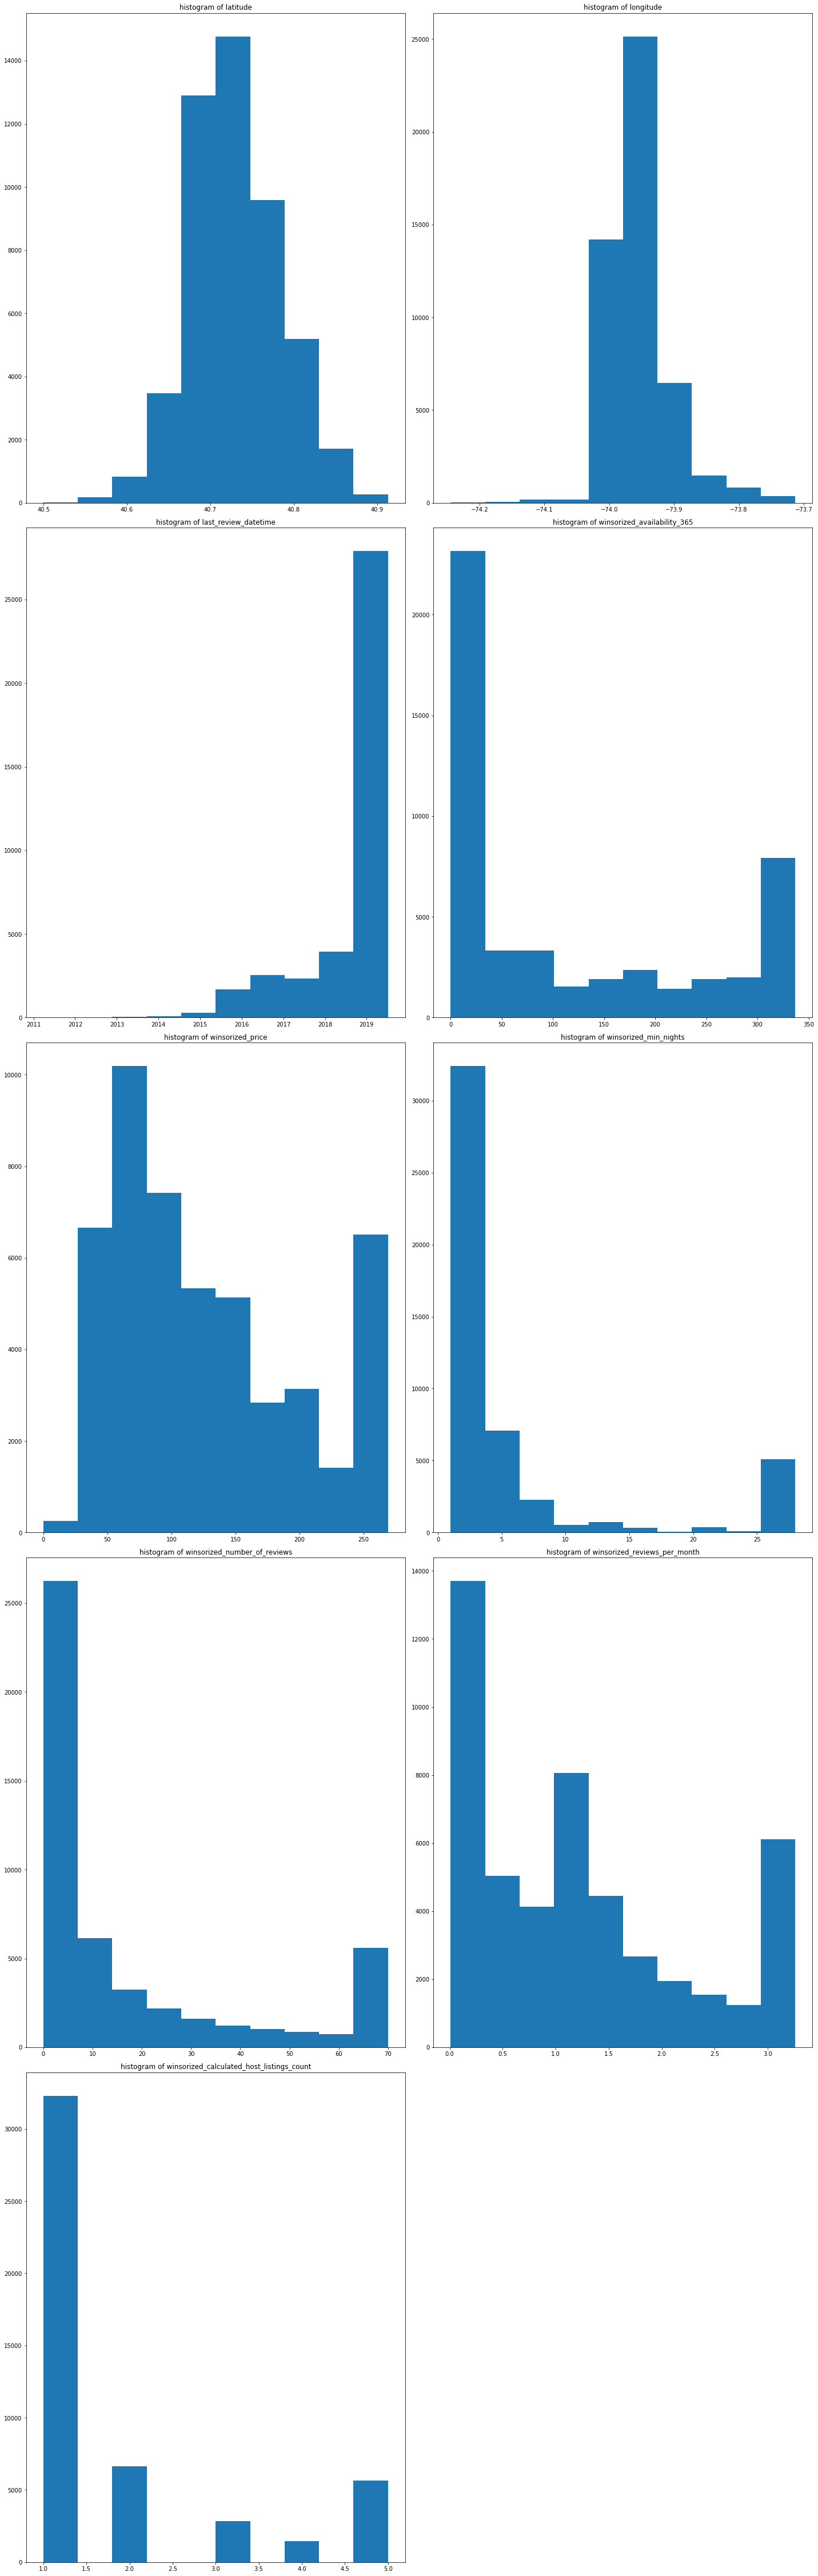

In [ ]:
fig = plt.figure(figsize=(20,100))

for i, col in enumerate(columns_for_histograms):
  plt.subplot(len(numeric_columns), 2, i+1)
  plt.hist(df_2[col])
  plt.title('histogram of {}'.format(col))

plt.tight_layout()
plt.show()

In [ ]:
#I am now going to create bar charts for the categorical columns. 
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']

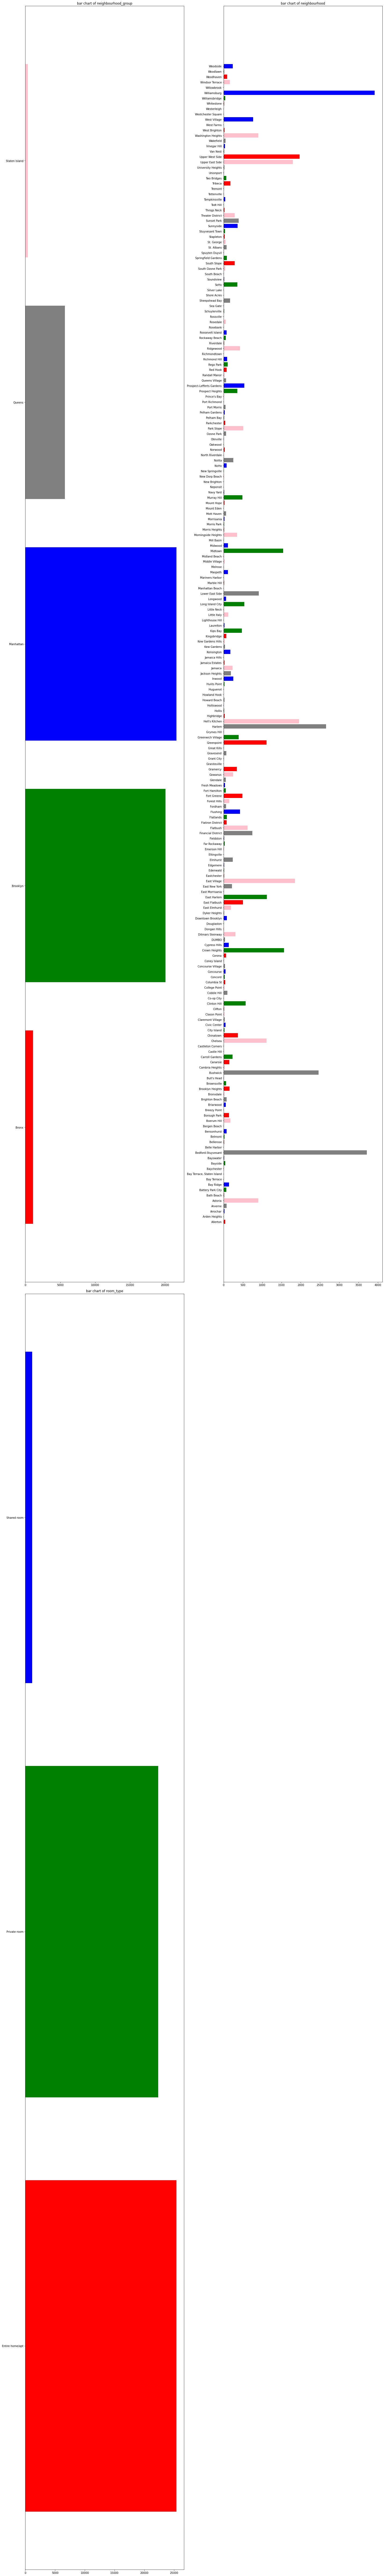

In [ ]:
fig = plt.figure(figsize=(20,200))

for i, col in enumerate(categorical_columns):
  plt.subplot(len(categorical_columns), 2, i+1)
  plt.barh(df_2.groupby(col)[col].count().index, 
          df_2.groupby(col)[col].count(), 
          color=["red","green","blue","grey","pink"])
  plt.title('bar chart of {}'.format(col))

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation of latitude vs winsorized price')

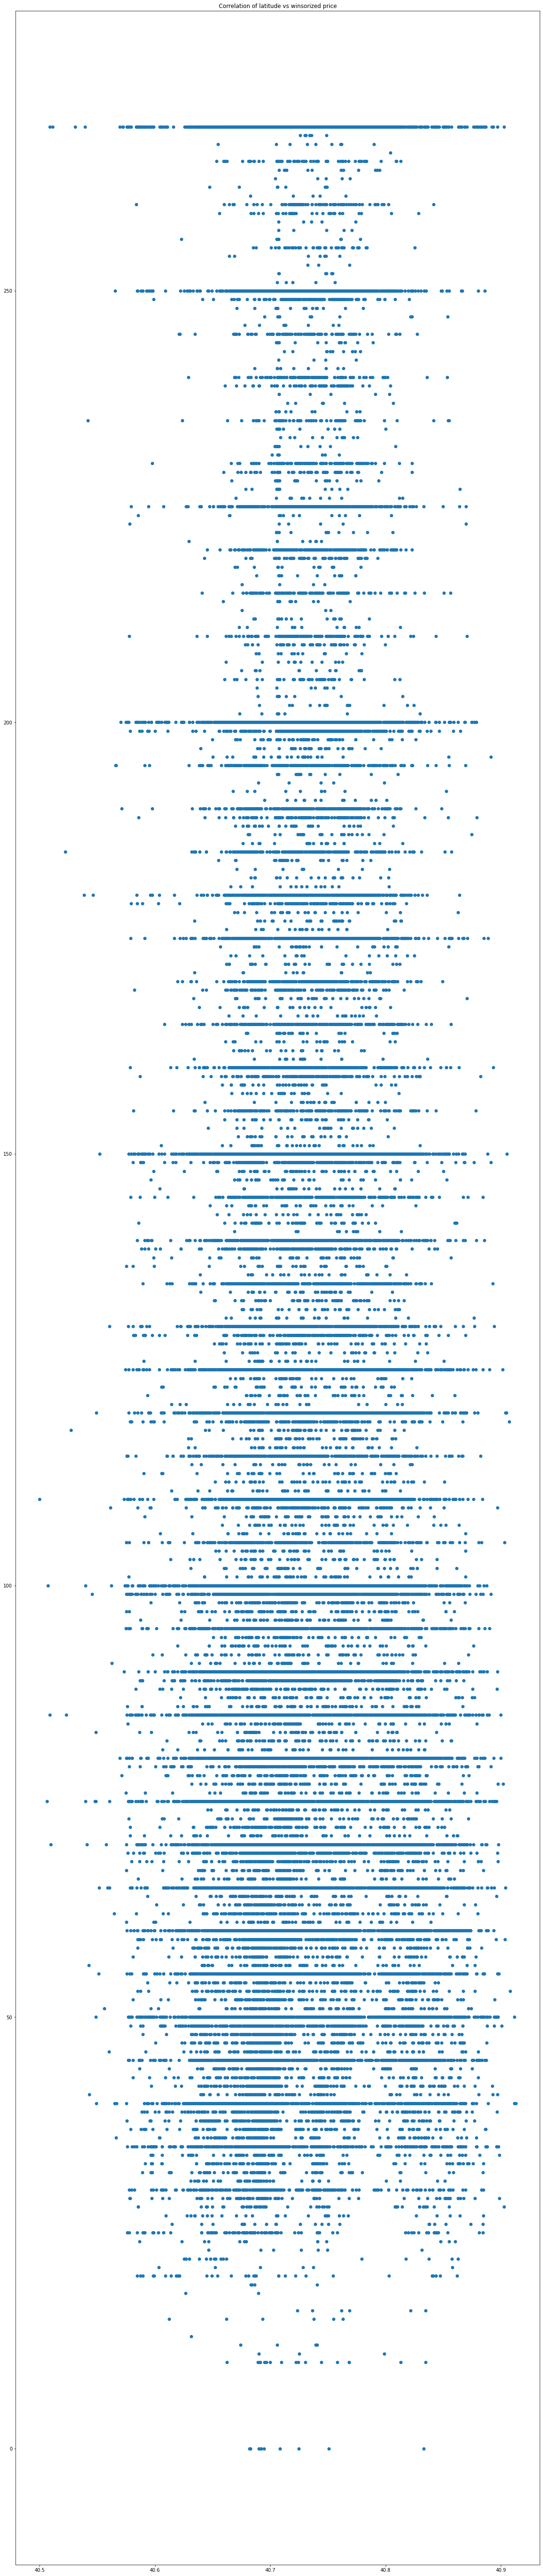

In [ ]:
#I am now going to create scatterplots for the numeric, continuous features to see how they correlate with the price. 
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['latitude'], df_2['winsorized_price'])
plt.title('Correlation of latitude vs winsorized price')

Text(0.5, 1.0, 'Correlation of longitude vs winsorized price')

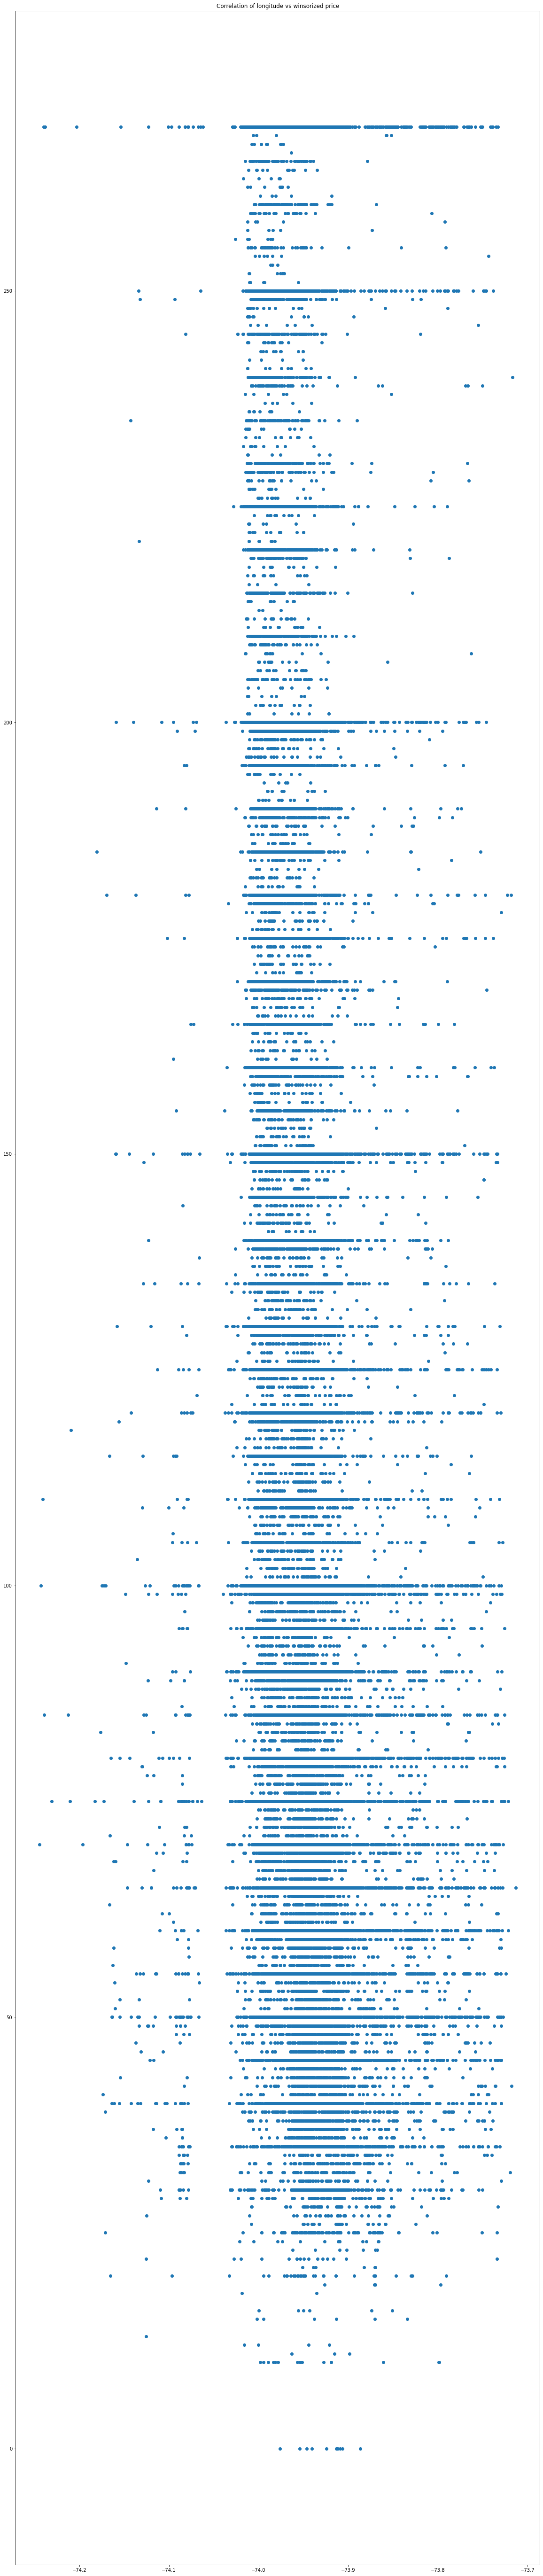

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['longitude'], df_2['winsorized_price'])
plt.title('Correlation of longitude vs winsorized price')

Text(0.5, 1.0, 'Correlation of last review vs winsorized price')

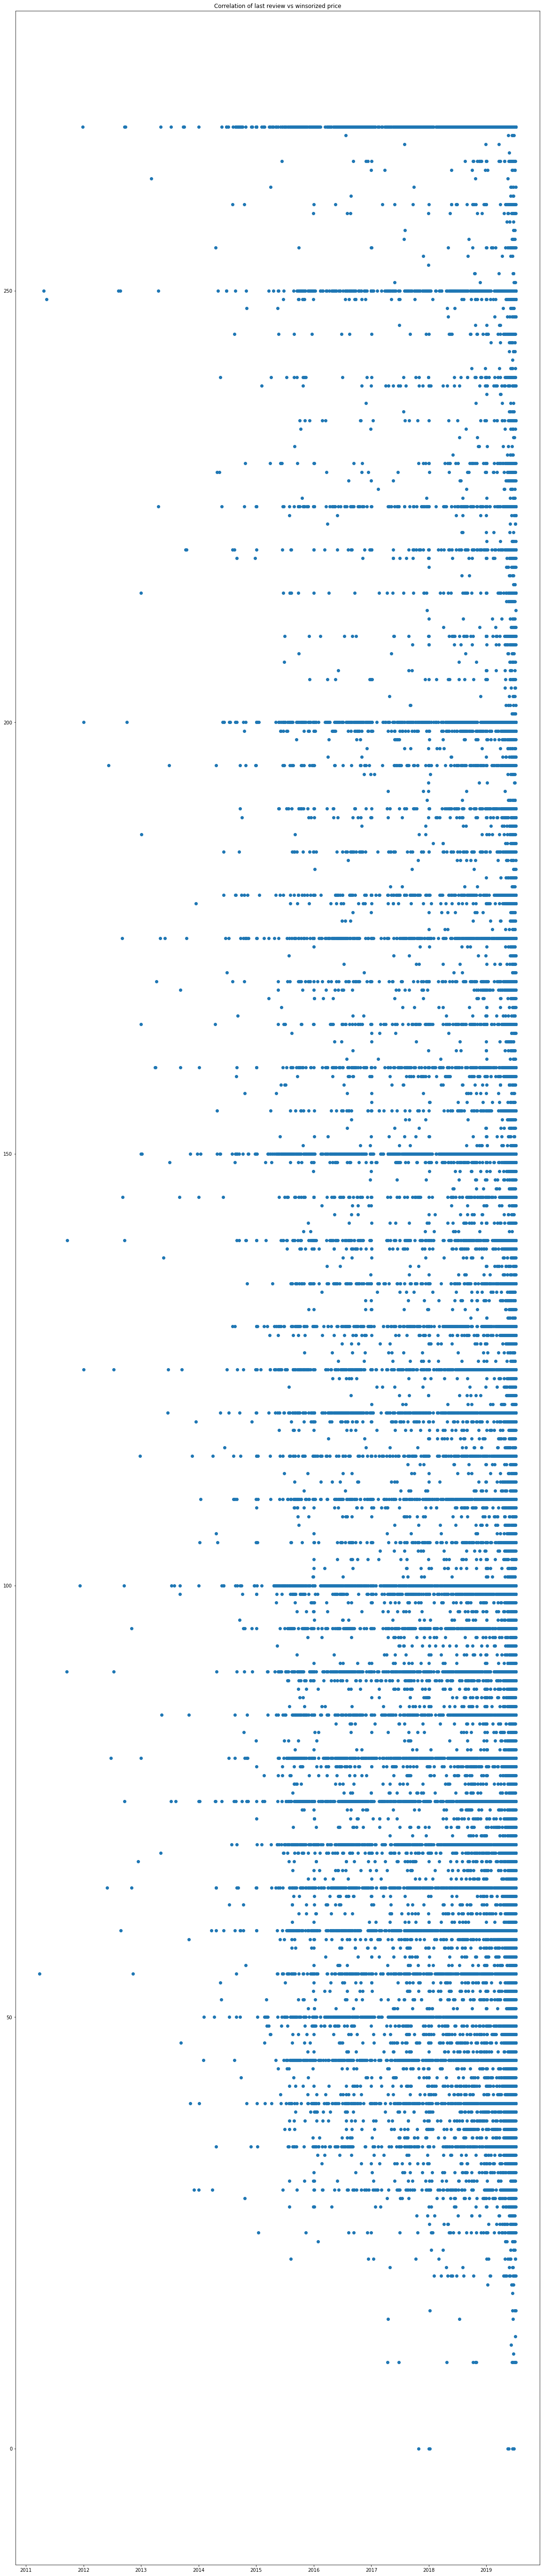

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['last_review_datetime'], df_2['winsorized_price'])
plt.title('Correlation of last review vs winsorized price')

Text(0.5, 1.0, 'Correlation of winsorized availability 365 vs winsorized price')

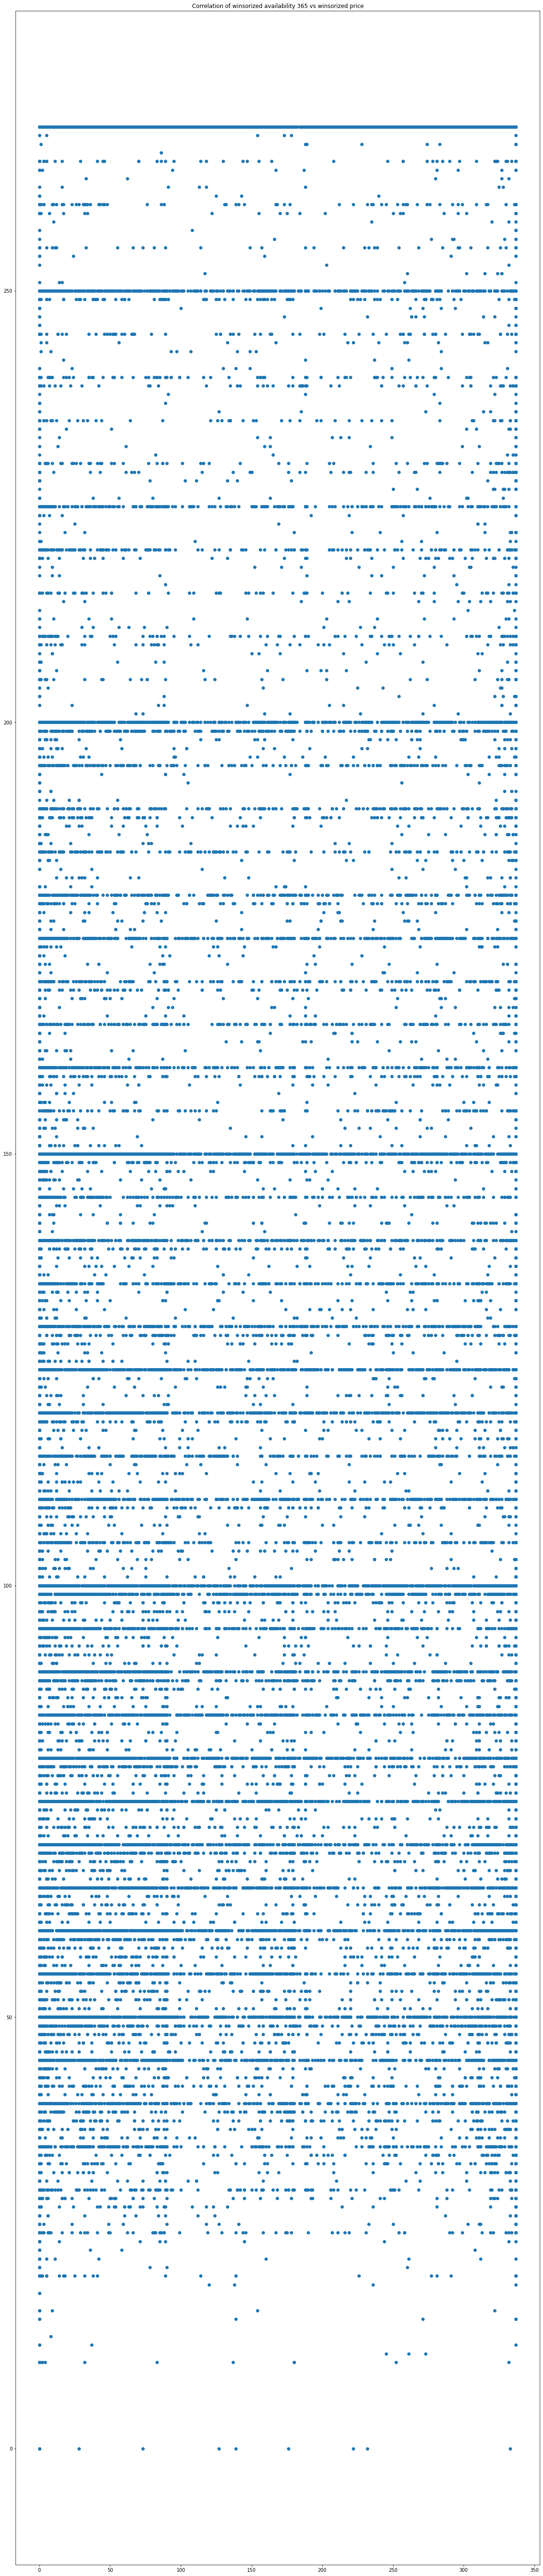

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['winsorized_availability_365'], df_2['winsorized_price'])
plt.title('Correlation of winsorized availability 365 vs winsorized price')

Text(0.5, 1.0, 'Correlation of winsorized minimum nights vs winsorized price')

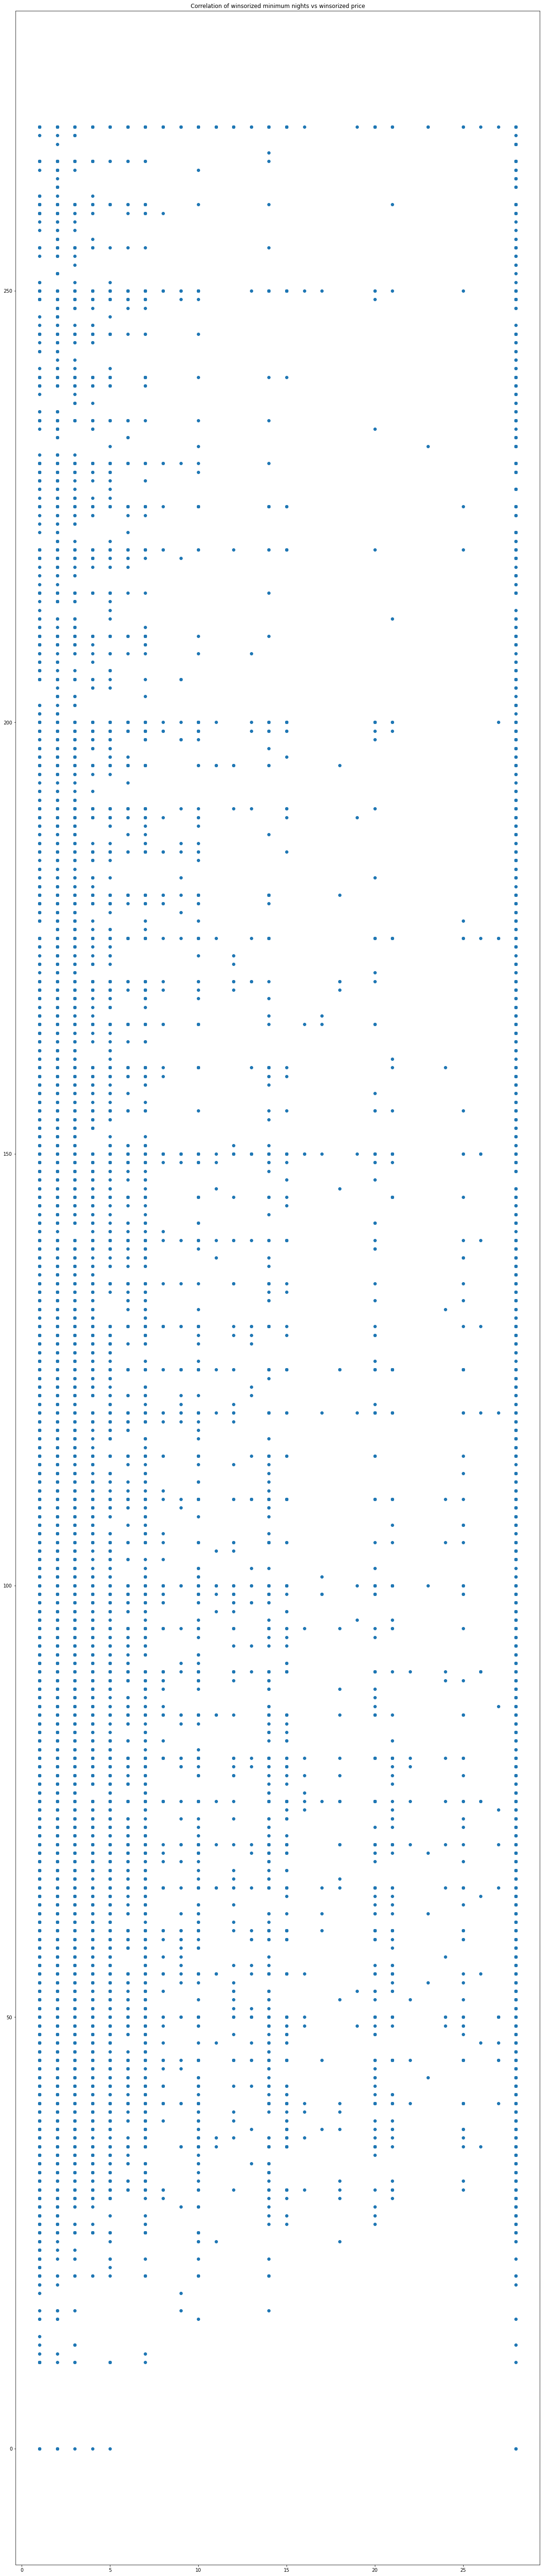

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['winsorized_min_nights'], df_2['winsorized_price'])
plt.title('Correlation of winsorized minimum nights vs winsorized price')

Text(0.5, 1.0, 'Correlation of winsorized number of reviews vs winsorized price')

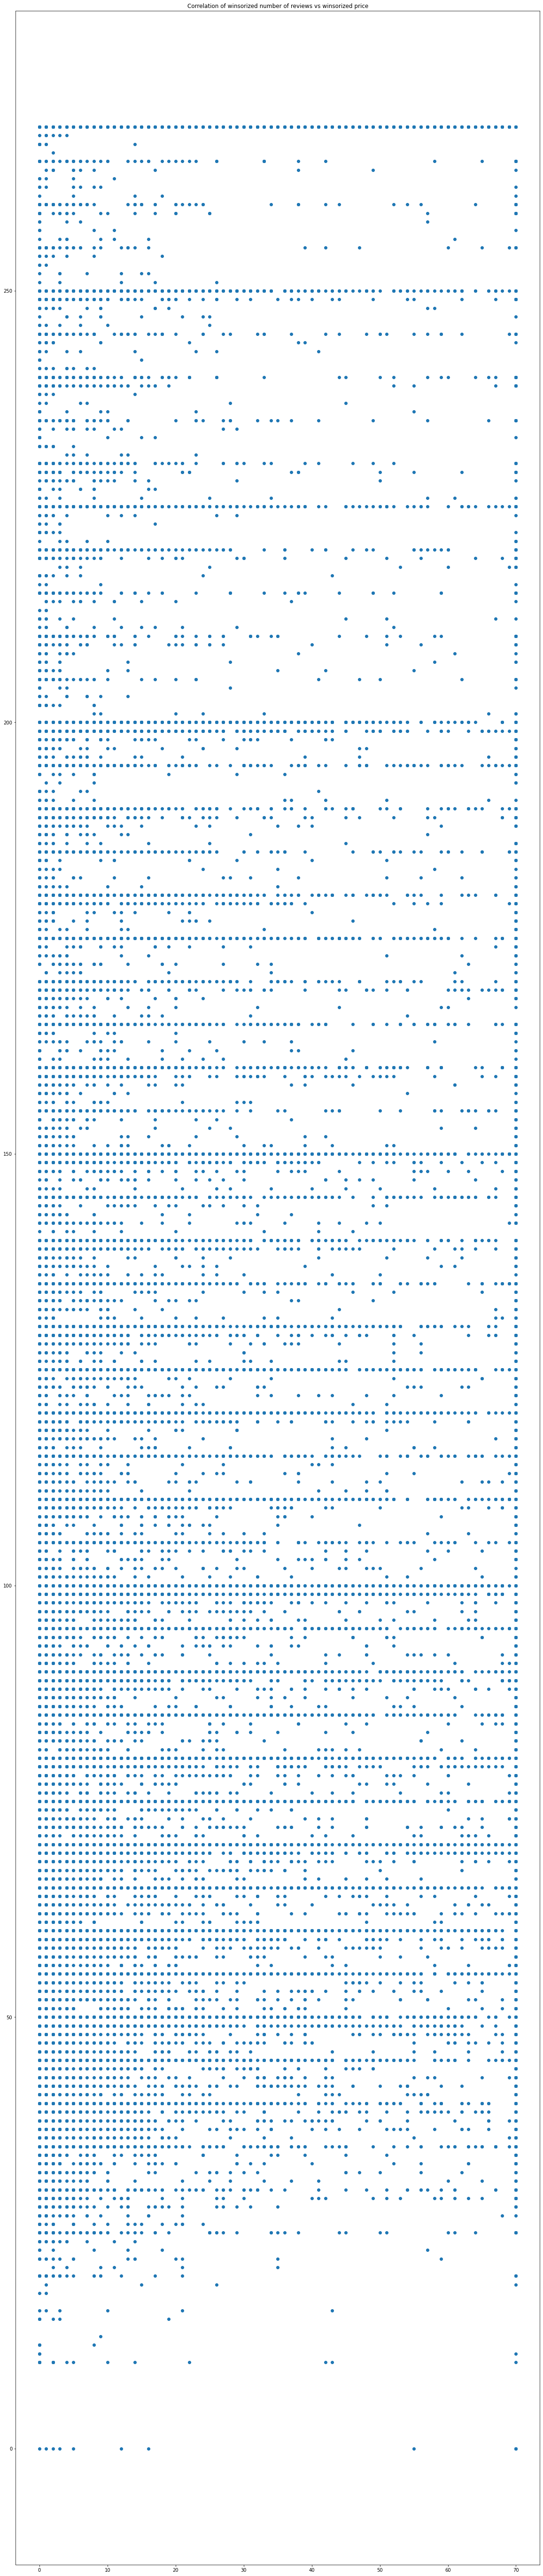

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['winsorized_number_of_reviews'], df_2['winsorized_price'])
plt.title('Correlation of winsorized number of reviews vs winsorized price')

Text(0.5, 1.0, 'Correlation of winsorized reviews per month vs winsorized price')

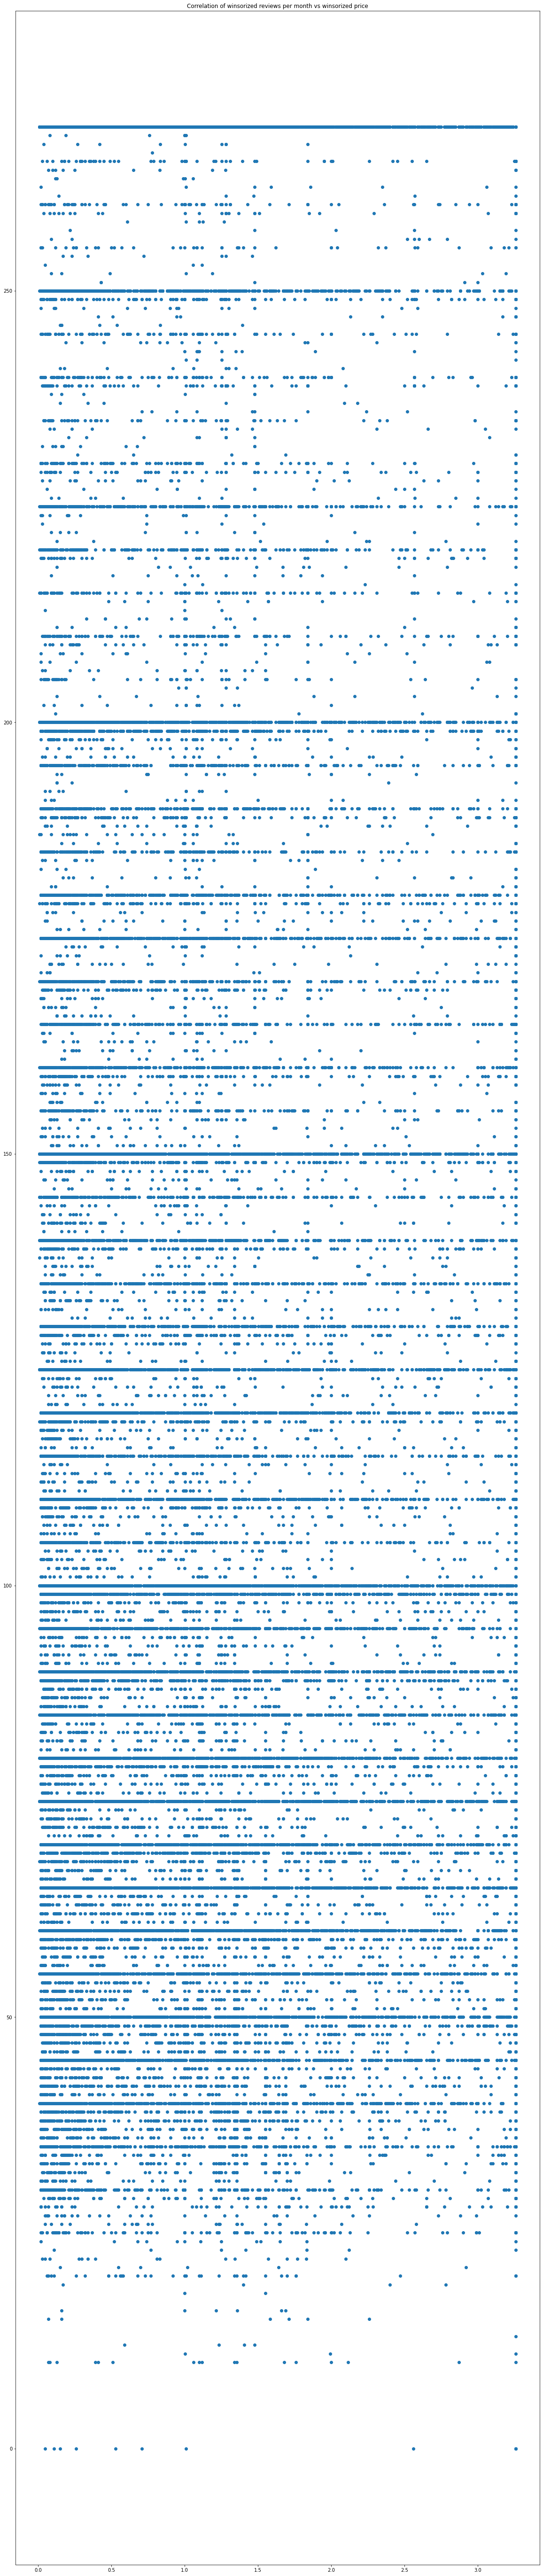

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['winsorized_reviews_per_month'], df_2['winsorized_price'])
plt.title('Correlation of winsorized reviews per month vs winsorized price')

Text(0.5, 1.0, 'Correlation of winsorized calculated host listings count vs winsorized price')

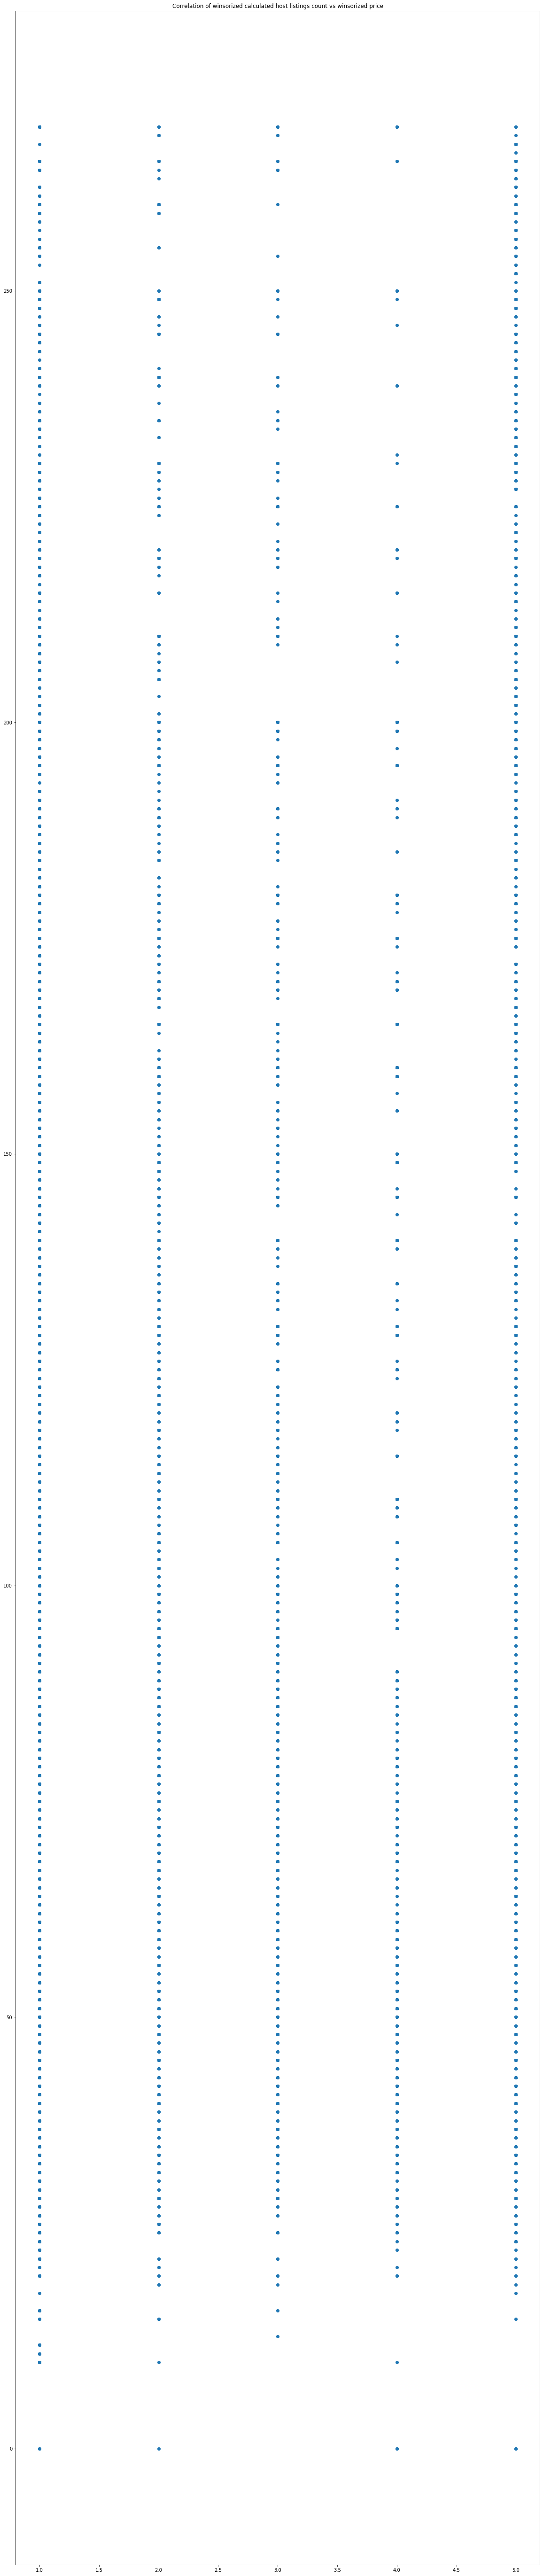

In [ ]:
fig = plt.figure(figsize=(20,100))
plt.scatter(df_2['winsorized_calculated_host_listings_count'], df_2['winsorized_price'])
plt.title('Correlation of winsorized calculated host listings count vs winsorized price')

In [ ]:
df_numeric = df_2[columns_for_histograms]
df_numeric.corr()

,latitude,longitude,winsorized_availability_365,winsorized_price,winsorized_min_nights,winsorized_number_of_reviews,winsorized_reviews_per_month,winsorized_calculated_host_listings_count
latitude,1.000000,0.084140,-0.011103,0.075863,0.045041,-0.024653,-0.012152,0.010171
longitude,0.084140,1.000000,0.081964,-0.325112,-0.107527,0.075954,0.142262,0.060935
winsorized_availability_365,-0.011103,0.081964,1.000000,0.103762,0.242987,0.199631,0.214908,0.425340
winsorized_price,0.075863,-0.325112,0.103762,1.000000,0.062236,-0.058356,-0.022519,-0.040325
winsorized_min_nights,0.045041,-0.107527,0.242987,0.062236,1.000000,-0.186206,-0.186815,0.334892
winsorized_number_of_reviews,-0.024653,0.075954,0.199631,-0.058356,-0.186206,1.000000,0.565169,0.014452
winsorized_reviews_per_month,-0.012152,0.142262,0.214908,-0.022519,-0.186815,0.565169,1.000000,0.088833
winsorized_calculated_host_listings_count,0.010171,0.060935,0.425340,-0.040325,0.334892,0.014452,0.088833,1.000000


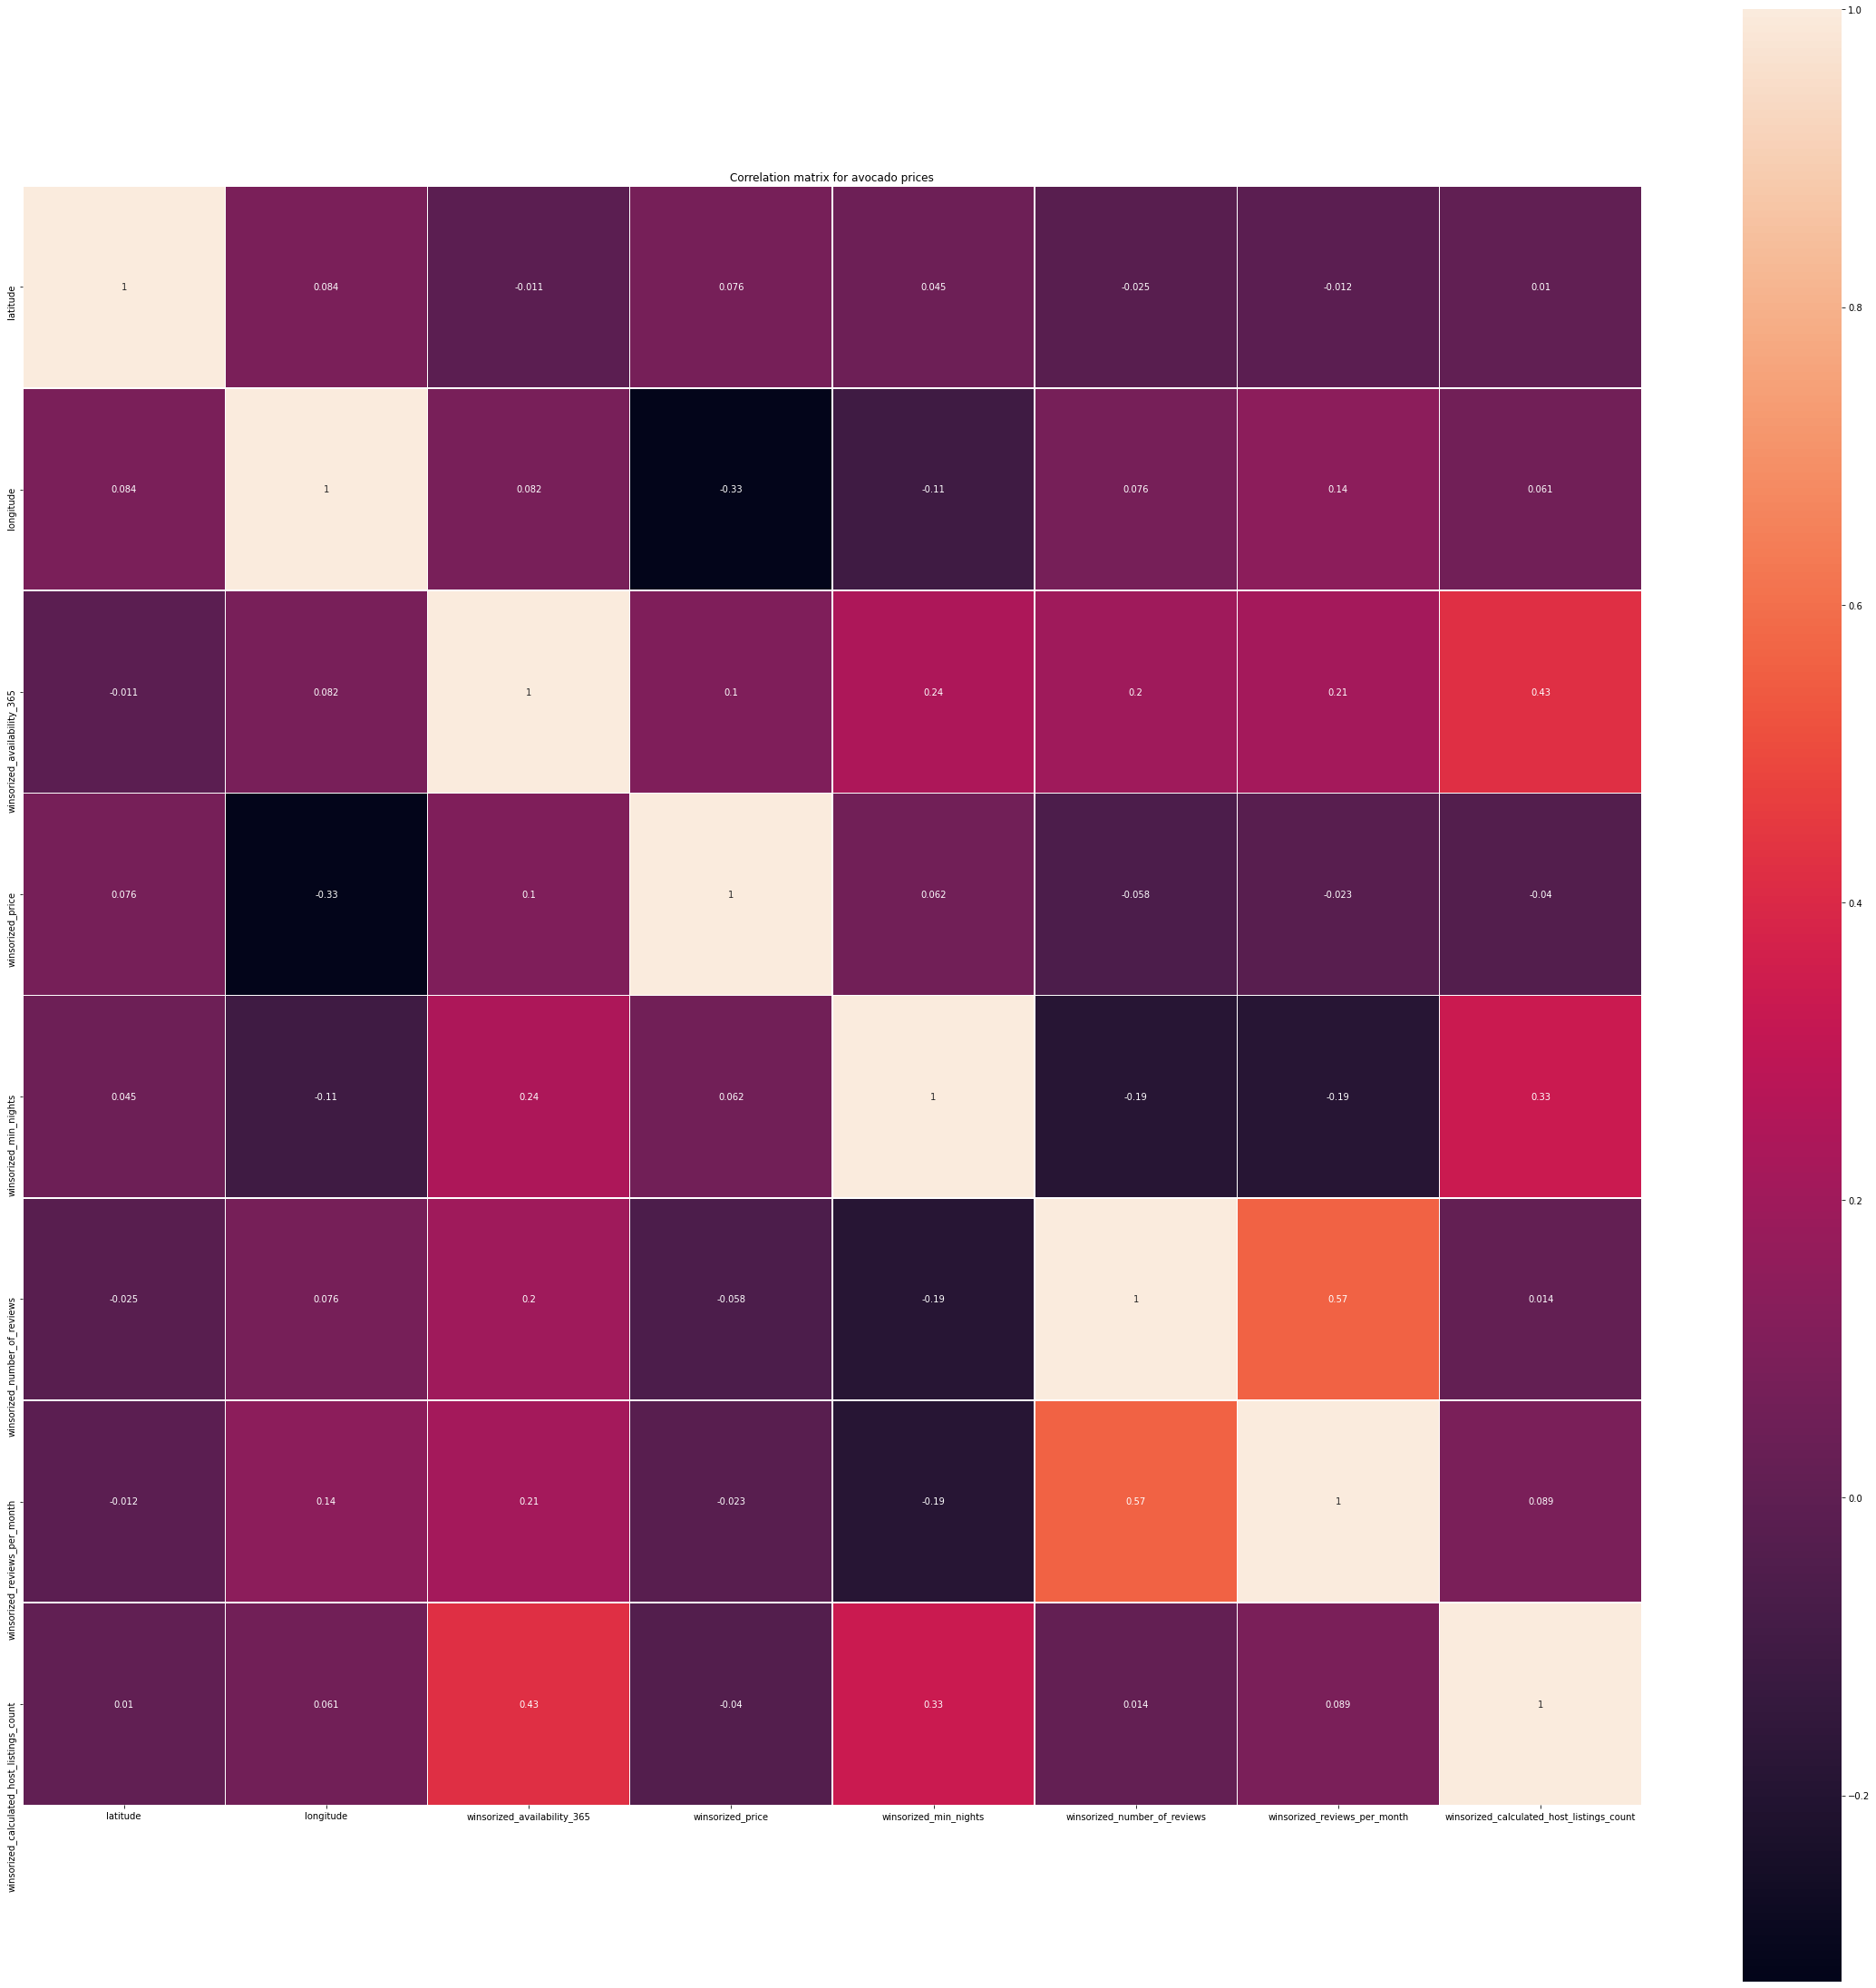

In [ ]:
import seaborn as sns
coormat = df_numeric.corr()

plt.figure(figsize=(40,40))
plt.title('Correlation matrix for avocado prices')

sns.heatmap(coormat, square=True, annot=True, linewidth= .5)
#as we can see from the heatmap and the correlations above, the only features that look to have somewhat of an influence on the price are availability 365
#and interestingly enough, longitude.

In [ ]:
df_categorical = df_2[categorical_columns]

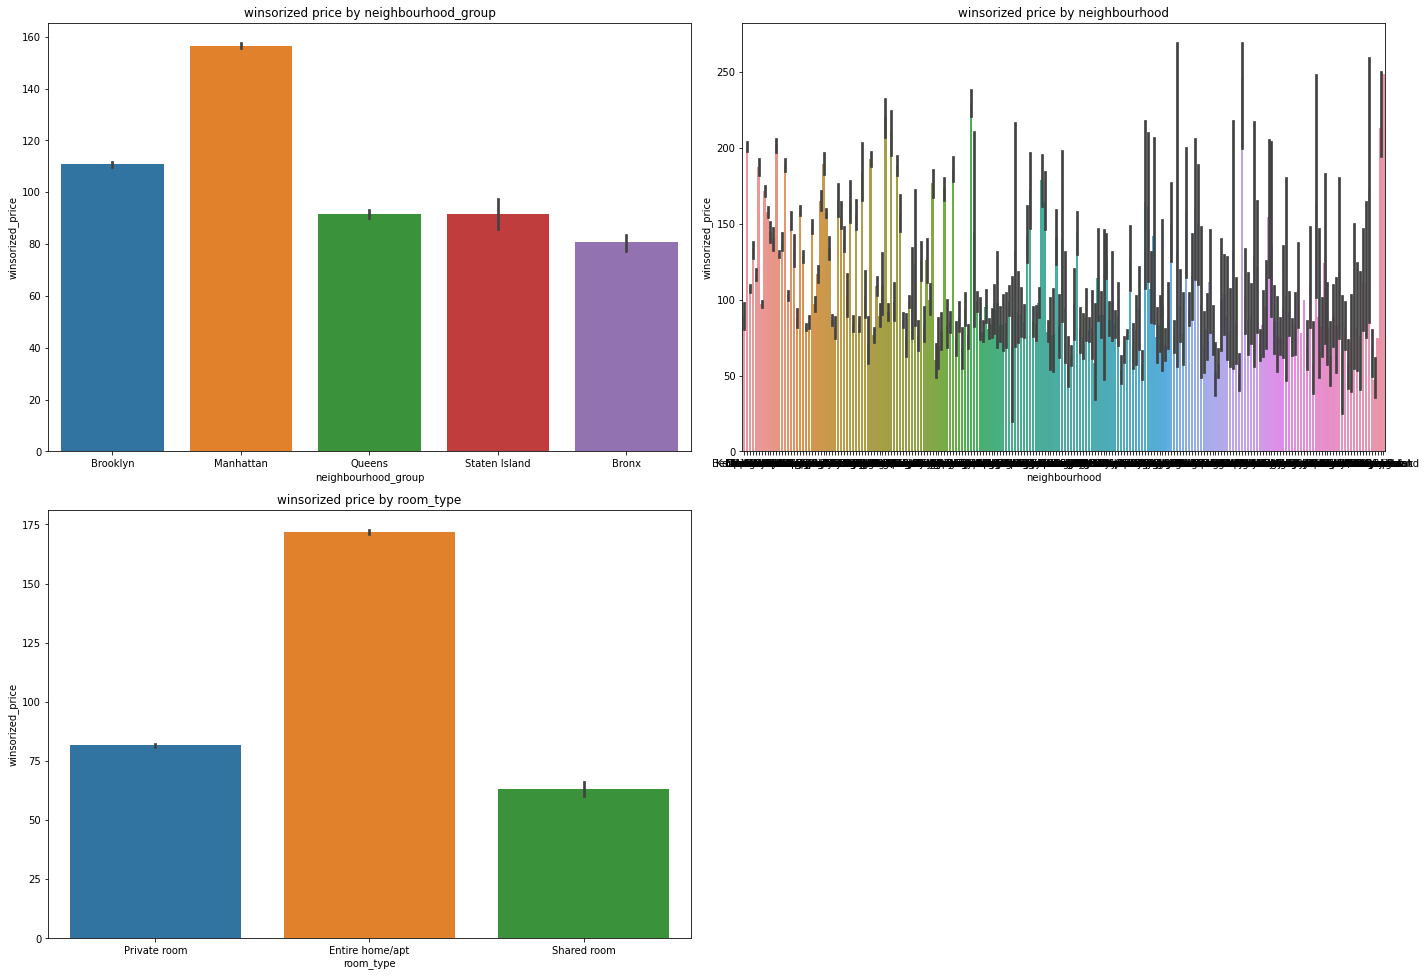

In [ ]:
fig = plt.figure(figsize=(20,20))

for i, col in enumerate(categorical_columns):
  plt.subplot(len(categorical_columns), 2, i+1)
  sns.barplot(df_2[col], df_2['winsorized_price'])
  plt.title('winsorized price by {}'.format(col))

plt.tight_layout()
plt.show()

## Feature Engineering
To begin the process of feature engineering, I am going to create dummies for the categorical variables. 

In [ ]:
dummy_data = pd.get_dummies(df_categorical.astype(str), drop_first=True)
dummy_data.head()

,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,neighbourhood_Chinatown,neighbourhood_City Island,...,neighbourhood_South Slope,neighbourhood_Springfield Gardens,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
numeric_and_dummies = pd.concat([df_numeric, dummy_data], axis=1)

In [ ]:
#On to investigate the correlations to see what features would be appropriate to use. 
corr_w_dummies = numeric_and_dummies.corr()
corr_w_dummies['winsorized_price'].sort_values()

room_type_Private room          -0.583618
longitude                       -0.325112
neighbourhood_group_Brooklyn    -0.198259
neighbourhood_group_Queens      -0.180442
neighbourhood_Bushwick          -0.146297
                                   ...   
neighbourhood_Chelsea            0.128049
neighbourhood_West Village       0.128229
neighbourhood_Midtown            0.181759
neighbourhood_group_Manhattan    0.349457
winsorized_price                 1.000000
Name: winsorized_price, Length: 231, dtype: float64

As shown in the above, we have some good features to work with. I am going to use private room, longitude, Brooklyn, Queens, and Manhattan. The reason why I am not using midtown or west village as a feature is because these are likely to be highly correlated with Manhattan

In [ ]:
#scaling and normalizing the data...
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

features_and_target = numeric_and_dummies[['winsorized_price', 'neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]

In [ ]:
features_and_target.head()

,winsorized_price,neighbourhood_group_Manhattan,room_type_Private room,longitude,neighbourhood_group_Brooklyn,neighbourhood_group_Queens
0,149,0,1,-73.97237,1,0
1,225,1,0,-73.98377,0,0
2,150,1,1,-73.94190,0,0
3,89,0,0,-73.95976,1,0
4,80,1,0,-73.94399,0,0


## Supervised Learning Models
To begin building the supervised learning models, I am going to start by building a regression model using the features selected above. 

In [ ]:
features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']] = StandardScaler().fit_transform(features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']])
features_and_target.head()

,winsorized_price,neighbourhood_group_Manhattan,room_type_Private room,longitude,neighbourhood_group_Brooklyn,neighbourhood_group_Queens
0,149,-0.891882,1.090831,-0.438079,1.196643,-0.362048
1,225,1.121224,-0.916732,-0.685177,-0.835671,-0.362048
2,150,1.121224,1.090831,0.222366,-0.835671,-0.362048
3,89,-0.891882,-0.916732,-0.164754,1.196643,-0.362048
4,80,1.121224,-0.916732,0.177065,-0.835671,-0.362048


In [ ]:
X = features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
Y = features_and_target['winsorized_price']

lrm = linear_model.LinearRegression()


lrm.fit(X, Y)


print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 24.10330436 -38.10894269 -11.75593177   9.39660161   8.66030479]

Intercept: 
 127.95760042542716


In [ ]:
import statsmodels.api as sm


X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       winsorized_price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     7286.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:58:59   Log-Likelihood:            -2.6536e+05
No. Observations:               48892   AIC:                         5.307e+05
Df Residuals:                   48886   BIC:                         5.308e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           127.9576      0.249    513.824      0.000     127.469     128.446
neighbourhood_group_Manhattan    24.1033      0.750     32.117      0.000      22.632      25.574
room_type_Private room          -38.1089      0.254   -149.775      0.000     -38.608     -37.610
longitude                       -11.7559      0.338    -34.757      0.000     -12.419     -11.093
neighbourhood_group_Brooklyn      9.3966      0.735     12.780      0.000       7.955      10.838
neighbourhood_group_Queens        8.6603      0.541     16.009      0.000       7.600       9.721
==============================================================================
Omnibus:                     2576.032   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3082.943
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.505   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Training set obs: {}".format(X_train.shape[0]))
print("Test set obs: {}".format(X_test.shape[0]))

Training set obs: 39113
Test set obs: 9779


In [ ]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()


results.summary()
#As shown in the below, this model doesn't explain too much of the target variable- only 42.7% of those. The p-value of the f-statistic us 0, so this tells us
#this information is useful

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       winsorized_price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     5824.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:58:59   Log-Likelihood:            -2.1235e+05
No. Observations:               39113   AIC:                         4.247e+05
Df Residuals:                   39107   BIC:                         4.248e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           128.0150      0.279    458.945      0.000     127.468     128.562
neighbourhood_group_Manhattan    23.8735      0.837     28.520      0.000      22.233      25.514
room_type_Private room          -38.0526      0.285   -133.388      0.000     -38.612     -37.493
longitude                       -11.7979      0.379    -31.145      0.000     -12.540     -11.055
neighbourhood_group_Brooklyn      8.9628      0.820     10.928      0.000       7.355      10.570
neighbourhood_group_Queens        8.5924      0.604     14.227      0.000       7.409       9.776
==============================================================================
Omnibus:                     2032.613   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2425.051
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                       3.497   Cond. No.                         6.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_test = sm.add_constant(X_test)

Y_pred = results.predict(X_test)

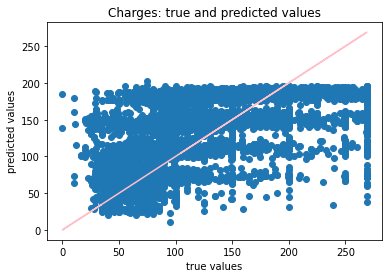

Mean absolute error: 41.98620512129246
Mean squared error: 2988.295736511505
Root mean squared error: 54.665306516212866
Mean absolute percentage error: inf


In [ ]:
plt.scatter(y_test, Y_pred)
plt.plot(y_test, y_test, color = 'pink')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error: {}".format(mean_absolute_error(y_test, Y_pred)))
print("Mean squared error: {}".format(mse(y_test, Y_pred)))
print("Root mean squared error: {}".format(rmse(y_test, Y_pred)))
print("Mean absolute percentage error: {}".format(np.mean(np.abs((y_test - Y_pred) / y_test)) * 100))

As we can see in the above, the mae, mse, and rmse are all on the low side so this is telling us this does do an okay job at predicting the values. if we look at the graph, however, we see that it is only good with the lower values. I will be playing around with the features to increase the accuracy of this analysis. 

In [ ]:
features_and_target['private_room_manhattan'] = features_and_target['neighbourhood_group_Manhattan'] * features_and_target['room_type_Private room']

In [ ]:
X = features_and_target[['private_room_manhattan','neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
Y = features_and_target['winsorized_price']

lrm = linear_model.LinearRegression()


lrm.fit(X, Y)


print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ -2.67942741  24.12486153 -38.19765686 -11.69609633   9.56470859
   8.60233177]

Intercept: 
 127.53473196709356


In [ ]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()
#The adjusted r-squared is only slightly stronger as the one without the new feature. However, the f-statistic is higher, the p-value for the f-statistic is still
#zero meaning this information is still useful
#one problem with this analysis is that the aic and bic values are higher than the previous ols analysis. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       winsorized_price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     6104.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:59:00   Log-Likelihood:            -2.6530e+05
No. Observations:               48892   AIC:                         5.306e+05
Df Residuals:                   48885   BIC:                         5.307e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           127.5347      0.252    506.206      0.000     127.041     128.029
private_room_manhattan           -2.6794      0.253    -10.574      0.000      -3.176      -2.183
neighbourhood_group_Manhattan    24.1249      0.750     32.182      0.000      22.656      25.594
room_type_Private room          -38.1977      0.254   -150.211      0.000     -38.696     -37.699
longitude                       -11.6961      0.338    -34.614      0.000     -12.358     -11.034
neighbourhood_group_Brooklyn      9.5647      0.735     13.020      0.000       8.125      11.005
neighbourhood_group_Queens        8.6023      0.540     15.919      0.000       7.543       9.661
==============================================================================
Omnibus:                     2815.007   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3462.169
Skew:                           0.581   Prob(JB):                         0.00
Kurtosis:                       3.592   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Training set obs: {}".format(X_train.shape[0]))
print("Test set obs: {}".format(X_test.shape[0]))

Training set obs: 39113
Test set obs: 9779


In [ ]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()


results.summary()
#Interestingly, the r-squared value is still the same as above, only slightly better than the first analysis. The AIC and BIC are lower than the first and second analysis
#which is a good sign that this model is doing a better job. An issue here is that the f-statistic is lower. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       winsorized_price   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     4878.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:59:00   Log-Likelihood:            -2.1231e+05
No. Observations:               39113   AIC:                         4.246e+05
Df Residuals:                   39106   BIC:                         4.247e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           127.5918      0.282    451.918      0.000     127.038     128.145
private_room_manhattan           -2.6372      0.284     -9.283      0.000      -3.194      -2.080
neighbourhood_group_Manhattan    23.8913      0.836     28.572      0.000      22.252      25.530
room_type_Private room          -38.1425      0.285   -133.771      0.000     -38.701     -37.584
longitude                       -11.7452      0.378    -31.037      0.000     -12.487     -11.003
neighbourhood_group_Brooklyn      9.1350      0.820     11.147      0.000       7.529      10.741
neighbourhood_group_Queens        8.5352      0.603     14.147      0.000       7.353       9.718
==============================================================================
Omnibus:                     2223.499   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2725.607
Skew:                           0.577   Prob(JB):                         0.00
Kurtosis:                       3.583   Cond. No.                         6.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X_test = sm.add_constant(X_test)

Y_pred = results.predict(X_test)

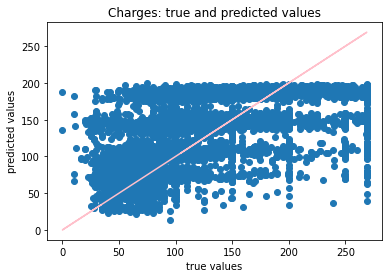

Mean absolute error: 41.772082609225436
Mean squared error: 2980.446030080706
Root mean squared error: 54.59346142241492
Mean absolute percentage error: inf


In [ ]:
plt.scatter(y_test, Y_pred)
plt.plot(y_test, y_test, color = 'pink')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error: {}".format(mean_absolute_error(y_test, Y_pred)))
print("Mean squared error: {}".format(mse(y_test, Y_pred)))
print("Root mean squared error: {}".format(rmse(y_test, Y_pred)))
print("Mean absolute percentage error: {}".format(np.mean(np.abs((y_test - Y_pred) / y_test)) * 100))
#as we can see in the graph and the figures below, the improvement is negligible. 

In [ ]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridge_reg = RidgeCV(alphas= alphas, cv=5)
ridge_reg.fit(X_train, y_train)
y_train_predictions = ridge_reg.predict(X_train)
y_test_predictions = ridge_reg.predict(X_test)

print("Best alpha value is: {}".format(ridge_reg.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(ridge_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
#the MAE, MSE, RMSE are all pretty much similar with the previous analyses. Ther-squared on the test set is slightly higher, at 42.9%.

Best alpha value is: 10.0
R-squared of the model in training set is: 0.4280539980408057
R-squared of the model in test set is: 0.42930442387037615
Mean absolute error of the prediction is: 41.77246509215342
Mean squared error of the prediction is: 2980.47639878359
Root mean squared error of the prediction is: 54.59373955668901
Mean absolute percentage error of the prediction is: inf


In [ ]:
lasso_reg = LassoCV(alphas=alphas, cv=5)

lasso_reg.fit(X_train, y_train)
y_train_predictions =  lasso_reg.predict(X_train)
y_test_predictions = lasso_reg.predict(X_test)

print("Best alpha value is: {}".format(lasso_reg.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(lasso_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))
#not much has changed as seen below...

Best alpha value is: 0.001
R-squared of the model in training set is: 0.42805415276864756
R-squared of the model in test set is: 0.42930873643753975
Mean absolute error of the prediction is: 41.77203500889221
Mean squared error of the prediction is: 2980.4538762598722
Root mean squared error of the prediction is: 54.593533282430734
Mean absolute percentage error of the prediction is: inf


In [ ]:
elasticnet_reg = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_reg.fit(X_train, y_train)
y_train_predictions =  elasticnet_reg.predict(X_train)
y_test_predictions = elasticnet_reg.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_reg.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_reg.score(X_train, y_train)))

print("R-squared of the model in test set is: {}".format(elasticnet_reg.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_predictions)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_predictions)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_predictions)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_predictions) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.428053447092247
R-squared of the model in test set is: 0.42929779825613346
Mean absolute error of the prediction is: 41.77284349033307
Mean squared error of the prediction is: 2980.511001271683
Root mean squared error of the prediction is: 54.59405646470761
Mean absolute percentage error of the prediction is: inf


As we can see in the above, the three regressions did not significantly improve the results, telling us that it is not needed.

## Next Model: K-Nearest Neighbors

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
#I am going to begin with getting the original data and normalizing it. 

In [ ]:
features_and_target = numeric_and_dummies[['winsorized_price', 'neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]

In [ ]:
features_and_target.head()

,winsorized_price,neighbourhood_group_Manhattan,room_type_Private room,longitude,neighbourhood_group_Brooklyn,neighbourhood_group_Queens
0,149,0,1,-73.97237,1,0
1,225,1,0,-73.98377,0,0
2,150,1,1,-73.94190,0,0
3,89,0,0,-73.95976,1,0
4,80,1,0,-73.94399,0,0


In [ ]:
#I am going to add in the additional feature of private rooms in manhattan. 
features_and_target['manhattan_private_room'] = features_and_target['neighbourhood_group_Manhattan'] * features_and_target['room_type_Private room']

In [ ]:
features_and_target.loc[:, features_and_target.columns != 'winsorized_price'] = preprocessing.normalize(features_and_target.loc[:, features_and_target.columns != 'winsorized_price'])

In [ ]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = features_and_target['winsorized_price']
X = features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
knn.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
#the accuracy wasn't too great here as shown below...at least these results are clear-cut here. I am going to try to weight this with the 'distance' weight. 

Unweighted Accuracy: 0.41 (+/- 0.05)


In [ ]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
Y = features_and_target['winsorized_price']
X = features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
knn.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
#this accuracy was even worse as we can see here.

Unweighted Accuracy: 0.20 (+/- 0.11)


Before moving on to the next machine learning method, I am going to try out various neighbor numbers to see if we can find the optimal number

In [ ]:
error_rate = []

for i in range(1,40):
 
 knn = neighbors.KNeighborsRegressor(n_neighbors=i)
 Y = features_and_target['winsorized_price']
 X = features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
 knn.fit(X,Y)
 score = cross_val_score(knn, X, Y, cv=5)
 print("Unweighted Accuracy for %0.2f neighbors: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std() * 2))

Unweighted Accuracy for 1.00 neighbors: -0.06 (+/- 0.17)
Unweighted Accuracy for 2.00 neighbors: 0.20 (+/- 0.11)
Unweighted Accuracy for 3.00 neighbors: 0.28 (+/- 0.08)
Unweighted Accuracy for 4.00 neighbors: 0.33 (+/- 0.07)
Unweighted Accuracy for 5.00 neighbors: 0.36 (+/- 0.07)
Unweighted Accuracy for 6.00 neighbors: 0.37 (+/- 0.06)
Unweighted Accuracy for 7.00 neighbors: 0.39 (+/- 0.06)
Unweighted Accuracy for 8.00 neighbors: 0.40 (+/- 0.06)
Unweighted Accuracy for 9.00 neighbors: 0.40 (+/- 0.06)
Unweighted Accuracy for 10.00 neighbors: 0.41 (+/- 0.05)
Unweighted Accuracy for 11.00 neighbors: 0.41 (+/- 0.05)
Unweighted Accuracy for 12.00 neighbors: 0.42 (+/- 0.05)
Unweighted Accuracy for 13.00 neighbors: 0.42 (+/- 0.05)
Unweighted Accuracy for 14.00 neighbors: 0.42 (+/- 0.05)
Unweighted Accuracy for 15.00 neighbors: 0.43 (+/- 0.05)
Unweighted Accuracy for 16.00 neighbors: 0.43 (+/- 0.05)
Unweighted Accuracy for 17.00 neighbors: 0.43 (+/- 0.05)
Unweighted Accuracy for 18.00 neighbors

As seen in the above, the highest accuracy is when there are 34 neighbors- it only reaches an r^2 of 0.45, however. 



## Random Forest Models

In [ ]:
#I am going to begin by gathering the features once more. 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble



features_and_target_2 = numeric_and_dummies[['winsorized_price', 'neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]

In [ ]:

features_and_target_2['manhattan_private_room'] = features_and_target_2['neighbourhood_group_Manhattan'] * features_and_target_2['room_type_Private room']

X = features_and_target_2[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens', 'manhattan_private_room']]
Y = features_and_target_2['winsorized_price']

In [ ]:
rfc = ensemble.RandomForestRegressor()
cross_val_score(rfc, X, Y, cv=5)
#as we can see below... it didn't perform too well. The fact that there is a variance between an r^2 of .19 to .31 poses as an issue. 

array([0.19029215, 0.21532599, 0.22946786, 0.28881868, 0.31763116])

In [ ]:
features_and_target_3 = numeric_and_dummies.drop(['last_review_datetime'], axis =1)
features_and_target_3.head()

,latitude,longitude,winsorized_availability_365,winsorized_price,winsorized_min_nights,winsorized_number_of_reviews,winsorized_reviews_per_month,winsorized_calculated_host_listings_count,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,...,neighbourhood_South Slope,neighbourhood_Springfield Gardens,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,337,149,1,9,0.210000,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,337,225,1,45,0.380000,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,337,150,3,0,1.340086,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,194,89,1,70,3.260000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,0,80,10,9,0.100000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#features_and_target_3['manhattan_private_room'] = features_and_target_3['neighbourhood_group_Manhattan'] *features_and_target_3['room_type_Private room']



In [ ]:
#X = features_and_target_3.drop(['winsorized_price'], axis=1)
#Y = features_and_target_3['winsorized_price']
#cross_val_score(rfc, X, Y, cv=5)
#Including all the features made an improvement, as seen below. 

SVM

In [ ]:
from sklearn.svm import SVR
svr = SVR()

features_and_target_4 = numeric_and_dummies.drop(['last_review_datetime'], axis =1)
features_and_target_4.head()

,latitude,longitude,winsorized_availability_365,winsorized_price,winsorized_min_nights,winsorized_number_of_reviews,winsorized_reviews_per_month,winsorized_calculated_host_listings_count,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,...,neighbourhood_South Slope,neighbourhood_Springfield Gardens,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,337,149,1,9,0.210000,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,337,225,1,45,0.380000,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,337,150,3,0,1.340086,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,194,89,1,70,3.260000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,0,80,10,9,0.100000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_and_target_4.loc[:, features_and_target_4.columns != 'winsorized_price'] = preprocessing.normalize(features_and_target_4.loc[:, features_and_target_4.columns != 'winsorized_price'])
features_and_target_4['manhattan_private_room'] = features_and_target_4['neighbourhood_group_Manhattan'] * features_and_target_4['room_type_Private room']

In [ ]:
Y = features_and_target_4['winsorized_price']
X = features_and_target_4[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens', 'manhattan_private_room']]

In [ ]:
cross_val_score(svr, X, Y, cv=5)
#compred to the k- nearest neighbors, this one performed even worse. 

array([-0.13769789, -0.01039496,  0.02169298, -0.01082268, -0.06606335])

## Gradient Boosting
I am now going to begin performing gradient boosting on the previous models. 

In [ ]:
X =features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens', 'manhattan_private_room']]
Y = features_and_target['winsorized_price']

preds = pd.DataFrame()
labels = []

for m in range(0, 101):
    
    
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,Y)
    
    
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    
    Y = Y - pred


predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(features_and_target['winsorized_price'], predicted)[0, 1])


Overall R^2:
0.6486573958213244


As we can see from the above- the gradient boosting has produced the strongest supervised learning model yet with an R^2 of .65- this is a substantial improvment compared to the other analyses. 

## Deep Learning: Neural Networks
I am now going to begin building deep learning models 

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
import keras
from tensorflow.keras.layers import LeakyReLU

Using TensorFlow backend.


In [ ]:
X =features_and_target[['neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens', 'manhattan_private_room']]
Y = features_and_target['winsorized_price']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense

In [ ]:
model = Sequential()

model.add(Dense(128, input_shape=(6,), activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
batch_size =64

model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 1s 1ms/step - loss: 68.1967 - mae: 68.1967
Epoch 2/20
612/612 [==============================] - 1s 1ms/step - loss: 59.4284 - mae: 59.4284
Epoch 3/20
612/612 [==============================] - 1s 1ms/step - loss: 59.3811 - mae: 59.3811
Epoch 4/20
612/612 [==============================] - 1s 1ms/step - loss: 59.3338 - mae: 59.3338
Epoch 5/20
612/612 [==============================] - 1s 1ms/step - loss: 59.2717 - mae: 59.2717
Epoch 6/20
612/612 [==============================] - 1s 1ms/step - loss: 59.2016 - mae: 59.2016
Epoch 7/20
612/612 [==============================] - 1s 1ms/step - loss: 59.0779 - mae: 59.0779
Epoch 8/20
612/612 [==============================] - 1s 1ms/step - loss: 58.9302 - mae: 58.9302
Epoch 9/20
612/612 [==============================] - 1s 1ms/step - loss: 58.7175 - mae: 58.7175
Epoch 10/20
612/612 [==============================] - 1s 1ms/step - loss: 58.3622 - mae: 58.3622
Epoch 11/20
612/612 [========

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#This looks to be problematic- the mean absolute error is high here. 59 is high when the price for a room could be $100. 

Test score: 53.97409439086914
Test MAE: 53.97409439086914


In [ ]:
#going to add more layers...
model = Sequential()

model.add(Dense(256, input_shape=(6,), activation="relu"))

model.add(Dense(128, activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 1s 2ms/step - loss: 67.1925 - mae: 67.1925
Epoch 2/20
612/612 [==============================] - 1s 2ms/step - loss: 59.5421 - mae: 59.5421
Epoch 3/20
612/612 [==============================] - 1s 2ms/step - loss: 59.4255 - mae: 59.4255
Epoch 4/20
612/612 [==============================] - 1s 2ms/step - loss: 59.2416 - mae: 59.2416
Epoch 5/20
612/612 [==============================] - 1s 2ms/step - loss: 58.9943 - mae: 58.9943
Epoch 6/20
612/612 [==============================] - 1s 2ms/step - loss: 58.4982 - mae: 58.4982
Epoch 7/20
612/612 [==============================] - 1s 2ms/step - loss: 58.3524 - mae: 58.3524
Epoch 8/20
612/612 [==============================] - 1s 2ms/step - loss: 58.2244 - mae: 58.2244
Epoch 9/20
612/612 [==============================] - 1s 2ms/step - loss: 57.4701 - mae: 57.4701
Epoch 10/20
612/612 [==============================] - 1s 2ms/step - loss: 57.1245 - mae: 57.1245
Epoch 11/20
612/612 [========

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#these results are only slightly better. 

Test score: 59.13568115234375
Test MAE: 59.13568115234375


In [ ]:
#I am going to add one more layer to bring it to 5 layers. 
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="relu"))

model.add(Dense(256, activation="relu"))

model.add(Dense(128, activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 3s 5ms/step - loss: 66.4274 - mae: 66.4274
Epoch 2/20
612/612 [==============================] - 3s 5ms/step - loss: 59.7670 - mae: 59.7670
Epoch 3/20
612/612 [==============================] - 3s 4ms/step - loss: 59.5569 - mae: 59.5569
Epoch 4/20
612/612 [==============================] - 2s 4ms/step - loss: 59.3286 - mae: 59.3286
Epoch 5/20
612/612 [==============================] - 3s 4ms/step - loss: 59.0406 - mae: 59.0406
Epoch 6/20
612/612 [==============================] - 2s 4ms/step - loss: 59.3099 - mae: 59.3099
Epoch 7/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4333 - mae: 59.4333
Epoch 8/20
612/612 [==============================] - 2s 4ms/step - loss: 59.5912 - mae: 59.5912
Epoch 9/20
612/612 [==============================] - 3s 4ms/step - loss: 59.6054 - mae: 59.6054
Epoch 10/20
612/612 [==============================] - 3s 4ms/step - loss: 59.6440 - mae: 59.6440
Epoch 11/20
612/612 [========

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#the performance is still not strong here. 

Test score: 59.73482131958008
Test MAE: 59.73482131958008


In [ ]:
#I am now going to tweak the activation functions to see if this will create any improvment. 
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="sigmoid"))

model.add(Dense(256, activation="sigmoid"))

model.add(Dense(128, activation="sigmoid"))

model.add(Dense(64, activation="sigmoid"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 3s 4ms/step - loss: 70.5733 - mae: 70.5733
Epoch 2/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4606 - mae: 59.4606
Epoch 3/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4576 - mae: 59.4576
Epoch 4/20
612/612 [==============================] - 3s 4ms/step - loss: 59.4573 - mae: 59.4573
Epoch 5/20
612/612 [==============================] - 3s 4ms/step - loss: 59.4574 - mae: 59.4574
Epoch 6/20
612/612 [==============================] - 3s 4ms/step - loss: 59.4572 - mae: 59.4572
Epoch 7/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4574 - mae: 59.4574
Epoch 8/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4570 - mae: 59.4570
Epoch 9/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4573 - mae: 59.4573
Epoch 10/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4572 - mae: 59.4572
Epoch 11/20
612/612 [========

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])

Test score: 58.8513069152832
Test MAE: 58.8513069152832


In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="tanh"))

model.add(Dense(256, activation="tanh"))

model.add(Dense(128, activation="tanh"))

model.add(Dense(64, activation="tanh"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 2s 4ms/step - loss: 67.8714 - mae: 67.8714
Epoch 2/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4587 - mae: 59.4587
Epoch 3/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4565 - mae: 59.4565
Epoch 4/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4574 - mae: 59.4574
Epoch 5/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4576 - mae: 59.4576
Epoch 6/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4568 - mae: 59.4568
Epoch 7/20
612/612 [==============================] - 2s 4ms/step - loss: 59.4552 - mae: 59.4552
Epoch 8/20
612/612 [==============================] - 3s 5ms/step - loss: 59.4562 - mae: 59.4562
Epoch 9/20
612/612 [==============================] - 3s 4ms/step - loss: 59.4565 - mae: 59.4565
Epoch 10/20
612/612 [==============================] - 3s 4ms/step - loss: 59.4558 - mae: 59.4558
Epoch 11/20
612/612 [========

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])

Test score: 58.85293197631836
Test MAE: 58.85293197631836


In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="softmax"))

model.add(Dense(256, activation="softmax"))

model.add(Dense(128, activation="softmax"))

model.add(Dense(64, activation="softmax"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 3s 5ms/step - loss: 124.9335 - mae: 124.9335
Epoch 2/20
612/612 [==============================] - 3s 4ms/step - loss: 118.7213 - mae: 118.7213
Epoch 3/20
612/612 [==============================] - 3s 4ms/step - loss: 112.5189 - mae: 112.5189
Epoch 4/20
612/612 [==============================] - 3s 4ms/step - loss: 106.3311 - mae: 106.3311
Epoch 5/20
612/612 [==============================] - 3s 4ms/step - loss: 100.2110 - mae: 100.2110
Epoch 6/20
612/612 [==============================] - 3s 4ms/step - loss: 94.3219 - mae: 94.3219
Epoch 7/20
612/612 [==============================] - 3s 4ms/step - loss: 88.9196 - mae: 88.9196
Epoch 8/20
612/612 [==============================] - 3s 4ms/step - loss: 84.1864 - mae: 84.1864
Epoch 9/20
612/612 [==============================] - 3s 4ms/step - loss: 80.1422 - mae: 80.1422
Epoch 10/20
612/612 [==============================] - 3s 5ms/step - loss: 76.8735 - mae: 76.8735
Epoch 11/20
612/612

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#the mse here was even worse. I'm going to stick to the 'tanh' activation function as this yielded the lowest results when playing around with the neuron numbers

Test score: 61.92014694213867
Test MAE: 61.92014694213867


In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 8s 13ms/step - loss: 62.3928 - mae: 62.3928
Epoch 2/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4674 - mae: 59.4674
Epoch 3/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4752 - mae: 59.4752
Epoch 4/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4723 - mae: 59.4723
Epoch 5/20
612/612 [==============================] - 8s 13ms/step - loss: 59.4530 - mae: 59.4530
Epoch 6/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4594 - mae: 59.4594
Epoch 7/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4702 - mae: 59.4702
Epoch 8/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4514 - mae: 59.4514
Epoch 9/20
612/612 [==============================] - 8s 12ms/step - loss: 59.4542 - mae: 59.4542
Epoch 10/20
612/612 [==============================] - 7s 12ms/step - loss: 59.4518 - mae: 59.4518
Epoch 11/20
612/612

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])

Test score: 93.25135803222656
Test MAE: 93.25135803222656


In [ ]:
model = Sequential()

model.add(Dense(64, input_shape=(6,), activation="tanh"))

model.add(Dense(8, activation="tanh"))

model.add(Dense(8, activation="tanh"))

model.add(Dense(8, activation="tanh"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=20, verbose=1)

Epoch 1/20
612/612 [==============================] - 1s 1ms/step - loss: 104.2896 - mae: 104.2896
Epoch 2/20
612/612 [==============================] - 1s 1ms/step - loss: 70.5216 - mae: 70.5216
Epoch 3/20
612/612 [==============================] - 1s 1ms/step - loss: 62.1083 - mae: 62.1083
Epoch 4/20
612/612 [==============================] - 1s 1ms/step - loss: 59.9727 - mae: 59.9727
Epoch 5/20
612/612 [==============================] - 1s 1ms/step - loss: 59.5302 - mae: 59.5302
Epoch 6/20
612/612 [==============================] - 1s 1ms/step - loss: 59.5074 - mae: 59.5074
Epoch 7/20
612/612 [==============================] - 1s 1ms/step - loss: 59.4888 - mae: 59.4888
Epoch 8/20
612/612 [==============================] - 1s 1ms/step - loss: 59.4742 - mae: 59.4742
Epoch 9/20
612/612 [==============================] - 1s 1ms/step - loss: 59.4621 - mae: 59.4621
Epoch 10/20
612/612 [==============================] - 1s 1ms/step - loss: 59.4547 - mae: 59.4547
Epoch 11/20
612/612 [======

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#the accuracy here is more or less the same. Now, I am going to be playing around with the batch sizes. 

Test score: 58.84721755981445
Test MAE: 58.84721755981445


In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1)

Epoch 1/20
3912/3912 [==============================] - 25s 6ms/step - loss: 60.0236 - mae: 60.0236
Epoch 2/20
3912/3912 [==============================] - 25s 6ms/step - loss: 59.5173 - mae: 59.5173
Epoch 3/20
3912/3912 [==============================] - 25s 6ms/step - loss: 59.5526 - mae: 59.5526
Epoch 4/20
3912/3912 [==============================] - 27s 7ms/step - loss: 59.5217 - mae: 59.5217
Epoch 5/20
3912/3912 [==============================] - 25s 6ms/step - loss: 59.5166 - mae: 59.5166
Epoch 6/20
3912/3912 [==============================] - 26s 7ms/step - loss: 59.5233 - mae: 59.5233
Epoch 7/20
3912/3912 [==============================] - 25s 6ms/step - loss: 59.4681 - mae: 59.4681
Epoch 8/20
3912/3912 [==============================] - 26s 7ms/step - loss: 59.4231 - mae: 59.4231
Epoch 9/20
3912/3912 [==============================] - 26s 7ms/step - loss: 59.1983 - mae: 59.1983
Epoch 10/20
3912/3912 [==============================] - 26s 7ms/step - loss: 58.4289 - mae: 58.4289

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#again, no difference in the mean squared error from what we were getting before. 

Test score: 53.480377197265625
Test MAE: 53.480377197265625


In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(6,), activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(512, activation="tanh"))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer='sgd', loss='MeanAbsoluteError',
              metrics=['mae'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1)

Epoch 1/20
306/306 [==============================] - 5s 17ms/step - loss: 65.0638 - mae: 65.0638
Epoch 2/20
306/306 [==============================] - 5s 18ms/step - loss: 59.4676 - mae: 59.4676
Epoch 3/20
306/306 [==============================] - 5s 18ms/step - loss: 59.4627 - mae: 59.4627
Epoch 4/20
306/306 [==============================] - 6s 18ms/step - loss: 59.4538 - mae: 59.4538
Epoch 5/20
306/306 [==============================] - 5s 18ms/step - loss: 59.4662 - mae: 59.4662
Epoch 6/20
306/306 [==============================] - 5s 17ms/step - loss: 59.4642 - mae: 59.4642
Epoch 7/20
306/306 [==============================] - 5s 18ms/step - loss: 59.4637 - mae: 59.4637
Epoch 8/20
306/306 [==============================] - 6s 18ms/step - loss: 59.4628 - mae: 59.4628
Epoch 9/20
306/306 [==============================] - 5s 18ms/step - loss: 59.4616 - mae: 59.4616
Epoch 10/20
306/306 [==============================] - 5s 17ms/step - loss: 59.4598 - mae: 59.4598
Epoch 11/20
306/306

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test MAE:', score[1])
#still not much of a difference.

Test score: 58.8457145690918
Test MAE: 58.8457145690918


As we can see from the above mean absolute errors for all of these deep learning models, we weren't able to minimize it to a value as low as we would like. The lowest we got is above, with a mean absolute error of 58.83. 

## Part 2: Using Unsupervised learning to segment similar places of stay

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import datasets, metrics
from scipy import stats
scaler = StandardScaler()

In [ ]:
features_and_target = numeric_and_dummies[['winsorized_price', 'neighbourhood_group_Manhattan', 'room_type_Private room', 'longitude', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens']]
#we will be using the target (price) as a feature here since there is no ground truth in this analysis. I am also going to add in the new feature of
#private rooms in manhattan. 

In [ ]:
features_and_target['private_room_manhattan'] = features_and_target['neighbourhood_group_Manhattan'] * features_and_target['room_type_Private room']

In [ ]:
#scaling the data...
X_std = scaler.fit_transform(features_and_target)

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)


X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=13579)

In [ ]:

ypred = pd.DataFrame()


for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    print(len(X_half1))
    print(len(X_pcahalf1))
    print(len(X_half2))
    print(len(X_pcahalf2))
    
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
   
    for nclust in range(2, 6):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

24446
24446
24446
24446
24446
24446
24446
24446


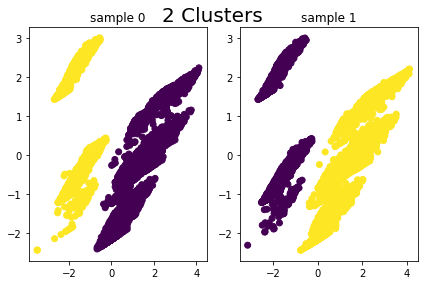

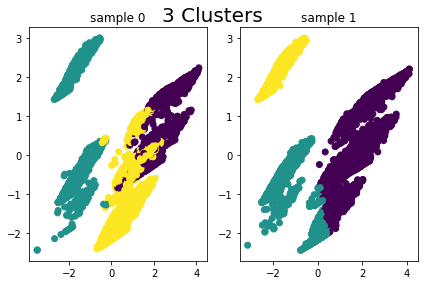

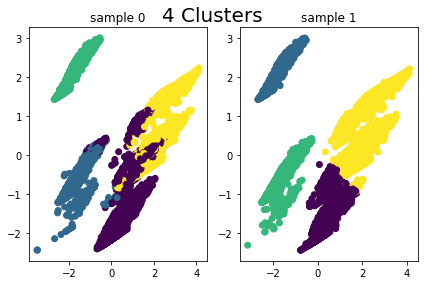

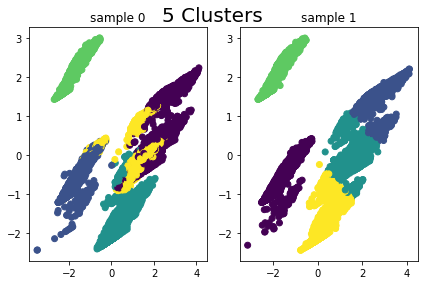

In [ ]:
for cluster in range(2, 6):
    
    
    f, axarr = plt.subplots(1, 2)
    
    
    for i in range(2):
        
        
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [ ]:
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#I am going to be testing out the shilouhette score for the above clusters along with 6-20 clusters. )

for number in n:
  labels = KMeans(n_clusters=number, random_state=123).fit_predict(X_std)
  print(metrics.silhouette_score(X_std, labels, metric='euclidean'))
#as we can see below, it performed strongest with 5 clusters.

0.36977237389741696
0.4476173832532004
0.5578093587502698
0.577737061316711
0.536811872377572
0.527004033452247
0.5103535158814438
0.5302364657518572
0.5373101999614082
0.5485914649496936
0.5208878485287642
0.5255738851213343
0.4633437784867697
0.4456457281931626
0.42372196778374405
0.44120874025684786
0.42303550447302435
0.41786796144494065
0.42586887495050796


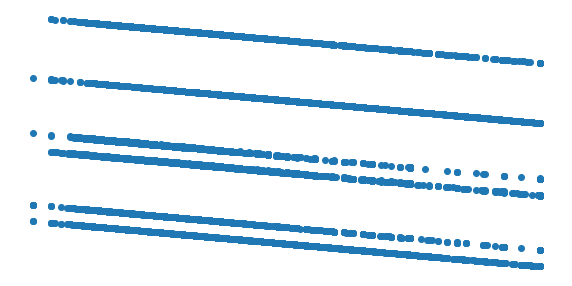

In [ ]:
#dimensionality reduction
pca = PCA(n_components=2)

pca_components = pca.fit_transform(features_and_target)
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
#as shown below, this did a really good job at limiting the number of clusters. 

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 48892 samples in 0.136s...
[t-SNE] Computed neighbors for 48892 samples in 5.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48892
[t-SNE] Computed conditional probabilities for sample 2000 / 48892
[t-SNE] Computed conditional probabilities for sample 3000 / 48892
[t-SNE] Computed conditional probabilities for sample 4000 / 48892
[t-SNE] Computed conditional probabilities for sample 5000 / 48892
[t-SNE] Computed conditional probabilities for sample 6000 / 48892
[t-SNE] Computed conditional probabilities for sample 7000 / 48892
[t-SNE] Computed conditional probabilities for sample 8000 / 48892
[t-SNE] Computed conditional probabilities for sample 9000 / 48892
[t-SNE] Computed conditional probabilities for sample 10000 / 48892
[t-SNE] Computed conditional probabilities for sample 11000 / 48892
[t-SNE] Computed conditional probabilities for sample 12000 / 48892
[t-SNE] Computed conditional probabilities for sa

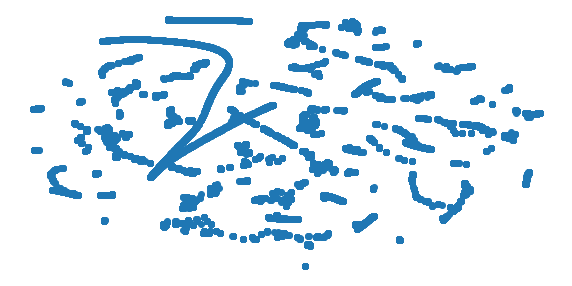

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=250)
tsne_results = tsne.fit_transform(features_and_target)
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
#After playing around with the number of components, perplexity and number of iterations, this has shown to produce most optimal results.

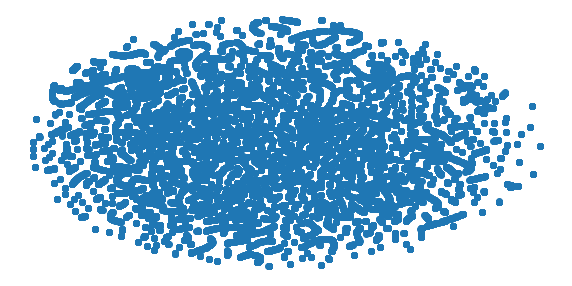

In [ ]:
import umap
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='correlation').fit_transform(features_and_target)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
#while not that great, this produced the best results.

Disclaimer about Gaussian Mixture Model, Agglomerative, and DBSCAN Clustering:
Unfortunately, with the data present, I was unable to perform an analysis with these forms of clustering as they crashed the kernel. 

## Key Takeaways
After performing several types of analyses with both supervised and deep learning, we were able to build several models that could reflect nightly price. While objectively not a very strong performer, the model that performed the strongest was gradient boosting, which gave us an r^2 value of 0.65. As for segmenting groups of apartments, the best clustering method was with K-means clustering at 5 clusters. As for dimensionality reduction, PCA did a very good job at reducing the dimensions. While these results were strong, it's worth noting that there were some big shortcomings. For starters, I think there could have been a stronger analysis if we had the date of the rentals. That way, we can see when apartments are expensive or not, depending on the time of the year. We could also get patterns about what times of the year certain neighbourhoods are popular and other ones aren't. Second, it would have been interesting to draw conclusions from the other clustering methods but the kernel kept crashing.